# Классификация изображений игральных карт

Загрузка необходимых библиотек и фреймворков:

In [42]:
import torch
import torch.nn as nn
import cv2
import torchvision as tv
import numpy as np
import json
import os
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from colorama import Fore
from pathlib import Path
import matplotlib.pyplot as plt

import torchvision.transforms.v2 as T

from time import time

DEVICE = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")

Device: mps


## Датасет

Загрузка датасета наборов игральных карт, хранящихся в виде:

- cards
  - set1
    - 2C.jpg
    - ...
    - KS.jpg
  - set2
    - ...
  - ...

In [43]:
class CardsDataset(Dataset):
    CARD_CLASSES = {
        "52": [
            ind + color for ind in map(str, list(range(2, 11)) + ["J", "Q", "K", "A"]) for color in ["C", "D", "H", "S"]
        ]
    }

    CARD_MULTILABEL_CLASSES = {
        "52": [
            (ind, color)
            for ind in map(str, list(range(2, 11)) + ["J", "Q", "K", "A"])
            for color in ["C", "D", "H", "S"]
        ]
    }

    def __init__(self, dir_path, cards_type="52", multilabel=False, transform=None):
        self.dir_path = dir_path
        self.cards_type = cards_type
        self.multilabel = multilabel
        if multilabel:
            self.classes = self.CARD_MULTILABEL_CLASSES[self.cards_type]
            indexes1 = set([row[0] for row in self.classes])
            indexes2 = set([row[1] for row in self.classes])
            self.ind2class1 = {i: cls for i, cls in enumerate(indexes1)}
            self.ind2class2 = {i: cls for i, cls in enumerate(indexes2)}
            self.class2ind1 = {cls: i for i, cls in self.ind2class1.items()}
            self.class2ind2 = {cls: i for i, cls in self.ind2class2.items()}
        else:
            self.classes = self.CARD_CLASSES[self.cards_type]
            self.ind2class = {i: cls for i, cls in enumerate(self.classes)}
            self.class2ind = {cls: i for i, cls in self.ind2class.items()}
        self.load_cards()
        self.transform = transform

    def load_cards(self):
        self.data = []
        for file in Path(self.dir_path).rglob("*"):
            if file.is_file():
                img = cv2.imread(file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if self.multilabel:
                    label1, label2 = file.stem[:-1], file.stem[-1]
                    self.data.append((img, (self.class2ind1[label1], self.class2ind2[label2])))
                else:
                    self.data.append((img, self.class2ind[file.stem]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, ind = self.data[index]
        if self.transform:
            img = self.transform(img)
        return img, ind

    def show_sample(self, start_i=0):
        plt.figure(figsize=(10, 5), facecolor="gray")

        for i in range(10):
            img, label = self[(start_i + i) * 5]
            plt.subplot(2, 5, i + 1)
            plt.imshow(img.permute(1, 2, 0).clip(0, 1))
            if self.multilabel:
                plt.title(f"{self.ind2class1[label[0]]} {self.ind2class2[label[1]]}")
            else:
                plt.title(self.ind2class[label])
            plt.axis("off")

        plt.show()

In [45]:
def collate_fn_multilabel(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return images, labels


def create_datasets_and_dataloaders(dir_path, multilabel=False, prob=0.2, batch_size=128):
    width = 57
    height = 89
    scale = height / width
    base = 128

    transforms = T.Compose(
        [
            T.ToImage(),
            T.Resize((int(base * scale), base)),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    test_dataset = CardsDataset(dir_path, transform=transforms, multilabel=multilabel)

    transforms = T.Compose(
        [
            T.ToImage(),
            # Random staff start
            T.RandomHorizontalFlip(p=prob),
            T.RandomVerticalFlip(p=prob),
            T.RandomRotation(180, expand=True),
            T.RandomPerspective(p=prob),
            T.RandomGrayscale(p=prob),
            T.RandomErasing(p=prob),
            T.RandomInvert(p=prob),
            # Random staff end
            T.Resize((int(base * scale), base)),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ).to(DEVICE)

    dataset = CardsDataset(dir_path, transform=transforms, multilabel=multilabel)

    if multilabel:
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn_multilabel,
        )
        test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_fn_multilabel,
        )
    else:
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
        )
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return dataset, dataloader, test_dataset, test_dataloader

In [46]:
onelabel_dataset, onelabel_dataloader, onelabel_test_dataset, onelabel_test_dataloader = (
    create_datasets_and_dataloaders("cards", multilabel=False)
)

(
    onelabel_untouched_dataset,
    onelabel_untouched_dataloader,
    onelabel_untouched_test_dataset,
    onelabel_untouched_test_dataloader,
) = create_datasets_and_dataloaders("cards_test", multilabel=False)

dataset, dataloader, test_dataset, test_dataloader = create_datasets_and_dataloaders("cards", multilabel=True)

untouched_dataset, untouched_dataloader, untouched_test_dataset, untouched_test_dataloader = (
    create_datasets_and_dataloaders("cards_test", multilabel=True)
)

Примеры "чистых" (анфас) игральных карт

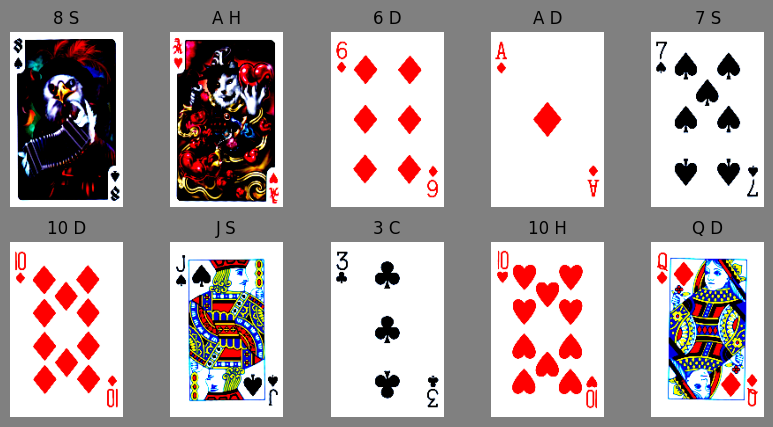

In [37]:
test_dataset.show_sample(50)

Примеры аугментированных изображений

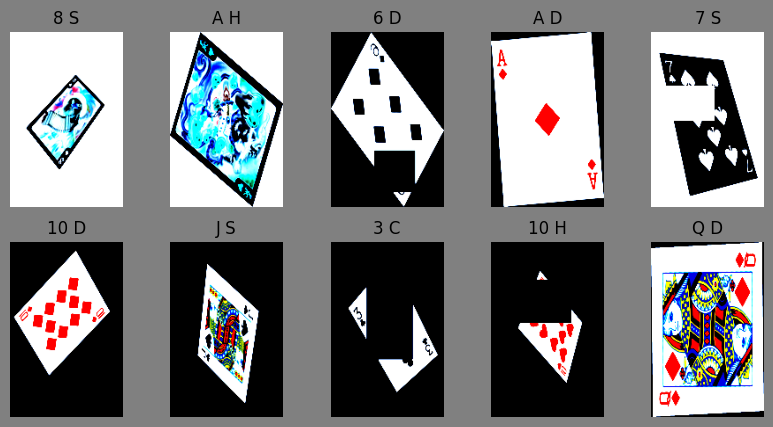

In [41]:
dataset.show_sample(50)

Набор, на котором модель не будет обучаться (будет использоваться для оценки адекватности)

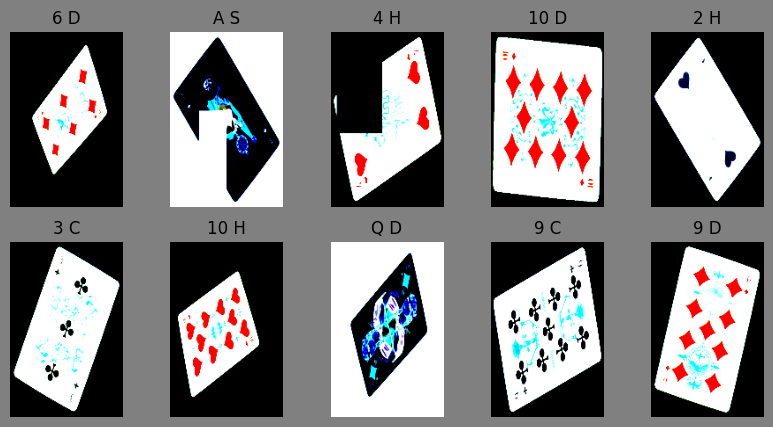

In [10]:
untouched_dataset.show_sample()

## Обучение

Объявим архитектуры для нашего классификатора:

In [74]:
class CardImageResolver(nn.Module):
    def __init__(self, backbone: nn.Module, classifier: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


class CardImageResolverMultilabel(nn.Module):
    def __init__(self, backbone: nn.Module, classifier1: nn.Module, classifier2: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.classifier1 = classifier1
        self.classifier2 = classifier2

    def forward(self, x):
        x = self.backbone(x)
        out1 = self.classifier1(x)
        out2 = self.classifier2(x)
        return out1, out2

И объявим сами backbone:

In [75]:
classifier = lambda inp_dim, out_dim: nn.Sequential(
    nn.Linear(inp_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(128, out_dim),
)

resnet_onelabel_freeze_backbone = tv.models.resnet18(weights=tv.models.ResNet18_Weights.IMAGENET1K_V1)
resnet_onelabel_freeze_backbone.fc = nn.Identity()

for param in resnet_onelabel_freeze_backbone.parameters():
    param.requires_grad = False

resnet_onelabel_backbone = tv.models.resnet18(weights=tv.models.ResNet18_Weights.IMAGENET1K_V1)
resnet_onelabel_backbone.fc = nn.Identity()

resnet_multilabel_backbone = tv.models.resnet18(weights=tv.models.ResNet18_Weights.IMAGENET1K_V1)
resnet_multilabel_backbone.fc = nn.Identity()

efficientnet_multilabel_backbone = tv.models.efficientnet_b0(weights=tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_multilabel_backbone.classifier = nn.Identity()

mobilenet_multilabel_backbone = tv.models.mobilenet_v3_large(weights=tv.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
mobilenet_multilabel_backbone.classifier = nn.Identity()

In [76]:
resnet_onelabel_freeze = CardImageResolver(resnet_onelabel_freeze_backbone, classifier(512, 52))
resnet_onelabel = CardImageResolver(resnet_onelabel_backbone, classifier(512, 52))
resnet_multilabel = CardImageResolverMultilabel(resnet_multilabel_backbone, classifier(512, 13), classifier(512, 4))

efficientnet_multilabel = CardImageResolverMultilabel(
    efficientnet_multilabel_backbone, classifier(1280, 13), classifier(1280, 4)
)

mobilenet_multilabel = CardImageResolverMultilabel(
    mobilenet_multilabel_backbone, classifier(960, 13), classifier(960, 4)
)

all_models = [resnet_onelabel_freeze, resnet_onelabel, resnet_multilabel, efficientnet_multilabel, mobilenet_multilabel]
all_models_names = [
    "resnet_onelabel_freeze",
    "resnet_onelabel",
    "resnet_multilabel",
    "efficientnet_multilabel",
    "mobilenet_multilabel",
]

for model, name in zip(all_models, all_models_names):
    print(name)
    print(f"Общее количество параметров: {sum(p.numel() for p in model.parameters()):>10}")
    print(f"           Из них обучаемые: {sum(p.numel() for p in model.parameters() if p.requires_grad):>10}")
    print()

resnet_onelabel_freeze
Общее количество параметров:   11248884
           Из них обучаемые:      72372

resnet_onelabel
Общее количество параметров:   11248884
           Из них обучаемые:   11248884

resnet_multilabel
Общее количество параметров:   11310033
           Из них обучаемые:   11310033

efficientnet_multilabel
Общее количество параметров:    4337677
           Из них обучаемые:    4337677

mobilenet_multilabel
Общее количество параметров:    3220161
           Из них обучаемые:    3220161



Функции для обучения, подсчёта, сохранения и визуализации метрик:

In [139]:
def compute_metrics(output, labels):
    _, predicted_top_1 = output.max(1)
    _, predicted_top_3 = output.topk(3, 1, True, True)
    hit1 = (predicted_top_1 == labels).sum().item()
    hit3 = (predicted_top_3 == labels.unsqueeze(1)).any(dim=1).sum().item()
    total = len(labels)

    return hit1, hit3, total


def compute_metrics_multilabel(output1, output2, labels1, labels2):
    _, predicted_top_1_first = output1.max(1)
    _, predicted_top_3_first = output1.topk(3, 1, True, True)
    hit1_first = (predicted_top_1_first == labels1).sum().item()
    hit3_first = (predicted_top_3_first == labels1.unsqueeze(1)).any(dim=1).sum().item()

    _, predicted_top_1_second = output2.max(1)
    _, predicted_top_3_second = output2.topk(3, 1, True, True)
    hit1_second = (predicted_top_1_second == labels2).sum().item()
    hit3_second = (predicted_top_3_second == labels2.unsqueeze(1)).any(dim=1).sum().item()

    hit1_full = ((predicted_top_1_first == labels1) & (predicted_top_1_second == labels2)).sum().item()

    mask_first = (predicted_top_3_first == labels1.unsqueeze(1)).any(dim=1)
    mask_second = (predicted_top_3_second == labels2.unsqueeze(1)).any(dim=1)
    hit3_full = (mask_first & mask_second).sum().item()

    total = len(labels1)

    return hit1_first, hit3_first, hit1_second, hit3_second, hit1_full, hit3_full, total


def train_epoch(model, optimizer, criterion, dataloader, epoch, multilabel=False, print_bar=False):
    model.train()
    epoch_loss = 0
    correct_hit1, correct_hit3, correct_hit1_full, correct_hit3_full, total = 0, 0, 0, 0, 0

    start_time = time()

    if print_bar:
        bar = tqdm(dataloader)
    else:
        bar = dataloader

    for i, (images, labels) in enumerate(bar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        if multilabel:
            out1, out2 = model(images)
            loss = criterion(out1, labels[:, 0]) + criterion(out2, labels[:, 1])
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            hit1_first, hit3_first, hit1_second, hit3_second, hit1_full, hit3_full, total_batch = (
                compute_metrics_multilabel(out1, out2, labels[:, 0], labels[:, 1])
            )

            correct_hit1 += hit1_first + hit1_second
            correct_hit3 += hit3_first + hit3_second
            correct_hit1_full += hit1_full
            correct_hit3_full += hit3_full
            total += total_batch
        else:
            out = model(images)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            hit1, hit3, total_batch = compute_metrics(out, labels)
            correct_hit1 += hit1
            correct_hit3 += hit3
            correct_hit1_full += hit1
            correct_hit3_full += hit3

            total += total_batch

        if multilabel:
            info = f"Epoch {epoch:>3} | Train Loss: {epoch_loss / (i + 1):.4f} | Train Hit@1: {correct_hit1_full / total:.4f} | Train Hit@3: {correct_hit3_full / total:.4f} | ({correct_hit1 / (total * 2):.4f} | {correct_hit3 / (total * 2):.4f})"
        else:
            info = f"Epoch {epoch:>3} | Train Loss: {epoch_loss / (i + 1):.4f} | Train Hit@1: {correct_hit1_full / total:.4f} | Train Hit@3: {correct_hit3_full / total:.4f}"

        if print_bar:
            bar.set_description(Fore.GREEN + info)

    if multilabel:
        total2 = total * 2
    else:
        total2 = total

    return (
        epoch_loss / len(dataloader),
        correct_hit1 / total2,
        correct_hit3 / total2,
        correct_hit1_full / total,
        correct_hit3_full / total,
        time() - start_time,
    )


def evaluate(model, criterion, dataloader, multilabel=False, print_bar=False):
    model.eval()
    epoch_loss = 0
    correct_hit1, correct_hit3, correct_hit1_full, correct_hit3_full, total = 0, 0, 0, 0, 0

    start_time = time()

    if print_bar:
        bar = tqdm(dataloader)
    else:
        bar = dataloader

    for i, (images, labels) in enumerate(bar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        if multilabel:
            out1, out2 = model(images)
            loss = criterion(out1, labels[:, 0]) + criterion(out2, labels[:, 1])

            epoch_loss += loss.item()

            hit1_first, hit3_first, hit1_second, hit3_second, hit1_full, hit3_full, total_batch = (
                compute_metrics_multilabel(out1, out2, labels[:, 0], labels[:, 1])
            )

            correct_hit1 += hit1_first + hit1_second
            correct_hit3 += hit3_first + hit3_second
            correct_hit1_full += hit1_full
            correct_hit3_full += hit3_full
            total += total_batch
        else:
            out = model(images)
            loss = criterion(out, labels)

            epoch_loss += loss.item()

            hit1, hit3, total_batch = compute_metrics(out, labels)
            correct_hit1 += hit1
            correct_hit3 += hit3
            correct_hit1_full += hit1
            correct_hit3_full += hit3

            total += total_batch

        if multilabel:
            info = f"          |  Test Loss: {epoch_loss / (i + 1):.4f} |  Test Hit@1: {correct_hit1_full / total:.4f} |  Test Hit@3: {correct_hit3_full / total:.4f} | ({correct_hit1 / (total * 2):.4f} | {correct_hit3 / (total * 2):.4f})"
        else:
            info = f"          |  Test Loss: {epoch_loss / (i + 1):.4f} |  Test Hit@1: {correct_hit1_full / total:.4f} |  Test Hit@3: {correct_hit3_full / total:.4f}"

        if print_bar:
            bar.set_description(Fore.YELLOW + info)

    if multilabel:
        total2 = total * 2
    else:
        total2 = total

    return (
        epoch_loss / len(dataloader),
        correct_hit1 / total2,
        correct_hit3 / total2,
        correct_hit1_full / total,
        correct_hit3_full / total,
        time() - start_time,
    )


def save(name, model, data):
    path = f"artifacts/{name}"
    if not os.path.exists("artifacts"):
        os.mkdir("artifacts")
    if not os.path.exists(path):
        os.mkdir(path)

    torch.save(model.state_dict(), f"{path}/model.pth")
    torch.save(model, f"{path}/model_full.pth")

    with open(f"{path}/data.json", "w") as f:
        json.dump(data, f, indent=4)


def load(name):
    path = f"artifacts/{name}"
    if not os.path.exists(path):
        raise ValueError(f"Model {name} not found")
    model = torch.load(f"{path}/model_full.pth", map_location=DEVICE, weights_only=False)
    with open(f"{path}/data.json", "r") as f:
        data = json.load(f)
    return model, data


def moving_average(x, ma=12):
    return pd.Series(x).rolling(ma, center=True).mean()


def plot_metrics(data, name="Model metrics", ma=12):
    plt.figure(figsize=(24, 8))

    plt.suptitle(name)

    plt.subplot(1, 3, 1)

    train_losses = [v["train_loss"] for v in data]
    test_losses = [v["test_loss"] for v in data]
    untouched_test_losses = [v["untouched_test_loss"] for v in data]

    plt.plot(np.array(train_losses), label="Train", alpha=0.2, linestyle="--", color="darkblue")
    plt.plot(np.array(test_losses), label="Test", alpha=0.2, linestyle="--", color="orange")
    plt.plot(np.array(untouched_test_losses), label="Untouched Test", alpha=0.2, linestyle="--", color="green")
    plt.plot(moving_average(np.array(train_losses), ma=ma), label="Train MA", color="darkblue")
    plt.plot(moving_average(np.array(test_losses), ma=ma), label="Test MA", color="orange")
    plt.plot(moving_average(np.array(untouched_test_losses), ma=ma), label="Untouched Test MA", color="green")

    plt.legend()
    plt.grid(alpha=0.5, linestyle=":")
    plt.xlabel("Epoch")
    plt.title("Loss")

    plt.subplot(1, 3, 2)

    train_hit1 = [v["train_hit1_full"] for v in data]
    test_hit1 = [v["test_hit1_full"] for v in data]
    untouched_test_hit1 = [v["untouched_test_hit1_full"] for v in data]

    plt.plot(np.array(train_hit1), label="Train", alpha=0.2, linestyle="--", color="darkblue")
    plt.plot(np.array(test_hit1), label="Test", alpha=0.2, linestyle="--", color="orange")
    plt.plot(np.array(untouched_test_hit1), label="Untouched Test", alpha=0.2, linestyle="--", color="green")
    plt.plot(moving_average(np.array(train_hit1), ma=ma), label="Train MA", color="darkblue")
    plt.plot(moving_average(np.array(test_hit1), ma=ma), label="Test MA", color="orange")
    plt.plot(moving_average(np.array(untouched_test_hit1), ma=ma), label="Untouched Test MA", color="green")

    plt.legend()
    plt.grid(alpha=0.5, linestyle=":")
    plt.xlabel("Epoch")
    plt.title("Accuracy")

    plt.subplot(1, 3, 3)

    train_hit3 = [v["train_hit3_full"] for v in data]
    test_hit3 = [v["test_hit3_full"] for v in data]
    untouched_test_hit3 = [v["untouched_test_hit3_full"] for v in data]

    plt.plot(np.array(train_hit3), label="Train", alpha=0.2, linestyle="--", color="darkblue")
    plt.plot(np.array(test_hit3), label="Test", alpha=0.2, linestyle="--", color="orange")
    plt.plot(np.array(untouched_test_hit3), label="Untouched Test", alpha=0.2, linestyle="--", color="green")
    plt.plot(moving_average(np.array(train_hit3), ma=ma), label="Train MA", color="darkblue")
    plt.plot(moving_average(np.array(test_hit3), ma=ma), label="Test MA", color="orange")
    plt.plot(moving_average(np.array(untouched_test_hit3), ma=ma), label="Untouched Test MA", color="green")

    plt.legend()
    plt.grid(alpha=0.5, linestyle=":")
    plt.xlabel("Epoch")
    plt.title("Hit@3")

    plt.show()


def full_train(
    model, name, n_epochs=500, multilabel=False, print_every=10, classifier_only=False, lr=0.001, use_untouched=False
):
    model = model.to(DEVICE)
    if classifier_only:
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    data = []

    if use_untouched:
        train_dataloader_inner = untouched_dataloader
        eval_dataloader_inner = untouched_test_dataloader
        test_dataloader_inner = untouched_test_dataloader
    elif multilabel:
        train_dataloader_inner = dataloader
        eval_dataloader_inner = test_dataloader
        test_dataloader_inner = untouched_test_dataloader
    else:
        train_dataloader_inner = onelabel_dataloader
        eval_dataloader_inner = onelabel_test_dataloader
        test_dataloader_inner = onelabel_untouched_test_dataloader

    for epoch in range(1, n_epochs + 1):
        epoch_data = {
            "epoch": epoch,
        }

        loss, hit1, hit3, hit1_full, hit3_full, times = train_epoch(
            model,
            optimizer,
            criterion,
            train_dataloader_inner,
            epoch,
            multilabel=multilabel,
            print_bar=not (epoch % print_every),
        )

        epoch_data["train_loss"] = loss
        epoch_data["train_hit1"] = hit1
        epoch_data["train_hit3"] = hit3
        epoch_data["train_hit1_full"] = hit1_full
        epoch_data["train_hit3_full"] = hit3_full
        epoch_data["train_time"] = times

        loss, hit1, hit3, hit1_full, hit3_full, times = evaluate(
            model, criterion, eval_dataloader_inner, multilabel=multilabel, print_bar=not (epoch % print_every)
        )

        epoch_data["test_loss"] = loss
        epoch_data["test_hit1"] = hit1
        epoch_data["test_hit3"] = hit3
        epoch_data["test_hit1_full"] = hit1_full
        epoch_data["test_hit3_full"] = hit3_full
        epoch_data["test_time"] = times

        loss, hit1, hit3, hit1_full, hit3_full, times = evaluate(
            model, criterion, test_dataloader_inner, multilabel=multilabel, print_bar=not (epoch % print_every)
        )

        epoch_data["untouched_test_loss"] = loss
        epoch_data["untouched_test_hit1"] = hit1
        epoch_data["untouched_test_hit3"] = hit3
        epoch_data["untouched_test_hit1_full"] = hit1_full
        epoch_data["untouched_test_hit3_full"] = hit3_full
        epoch_data["untouched_test_time"] = times

        data.append(epoch_data)

        save(name, model, data)

    plot_metrics(data, name)

Ниже - обучения моделей с графиками основным метрик

Epoch  10 | Train Loss: 3.7587 | Train Hit@1: 0.0769 | Train Hit@3: 0.1923: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]
          |  Test Loss: 3.7202 |  Test Hit@1: 0.0662 |  Test Hit@3: 0.1902: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
          |  Test Loss: 3.6952 |  Test Hit@1: 0.0577 |  Test Hit@3: 0.1923: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
Epoch  20 | Train Loss: 3.4801 | Train Hit@1: 0.1261 | Train Hit@3: 0.2564: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]
          |  Test Loss: 3.3820 |  Test Hit@1: 0.1218 |  Test Hit@3: 0.2885: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
          |  Test Loss: 3.3560 |  Test Hit@1: 0.1154 |  Test Hit@3: 0.2692: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]
Epoch  30 | Train Loss: 3.2794 | Train Hit@1: 0.1432 | Train Hit@3: 0.3291: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]
          |  Test Loss: 3.1654 |  Test Hit@1: 0.1688 |  Test Hit@3: 0.3590: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]
          |  Test Loss: 

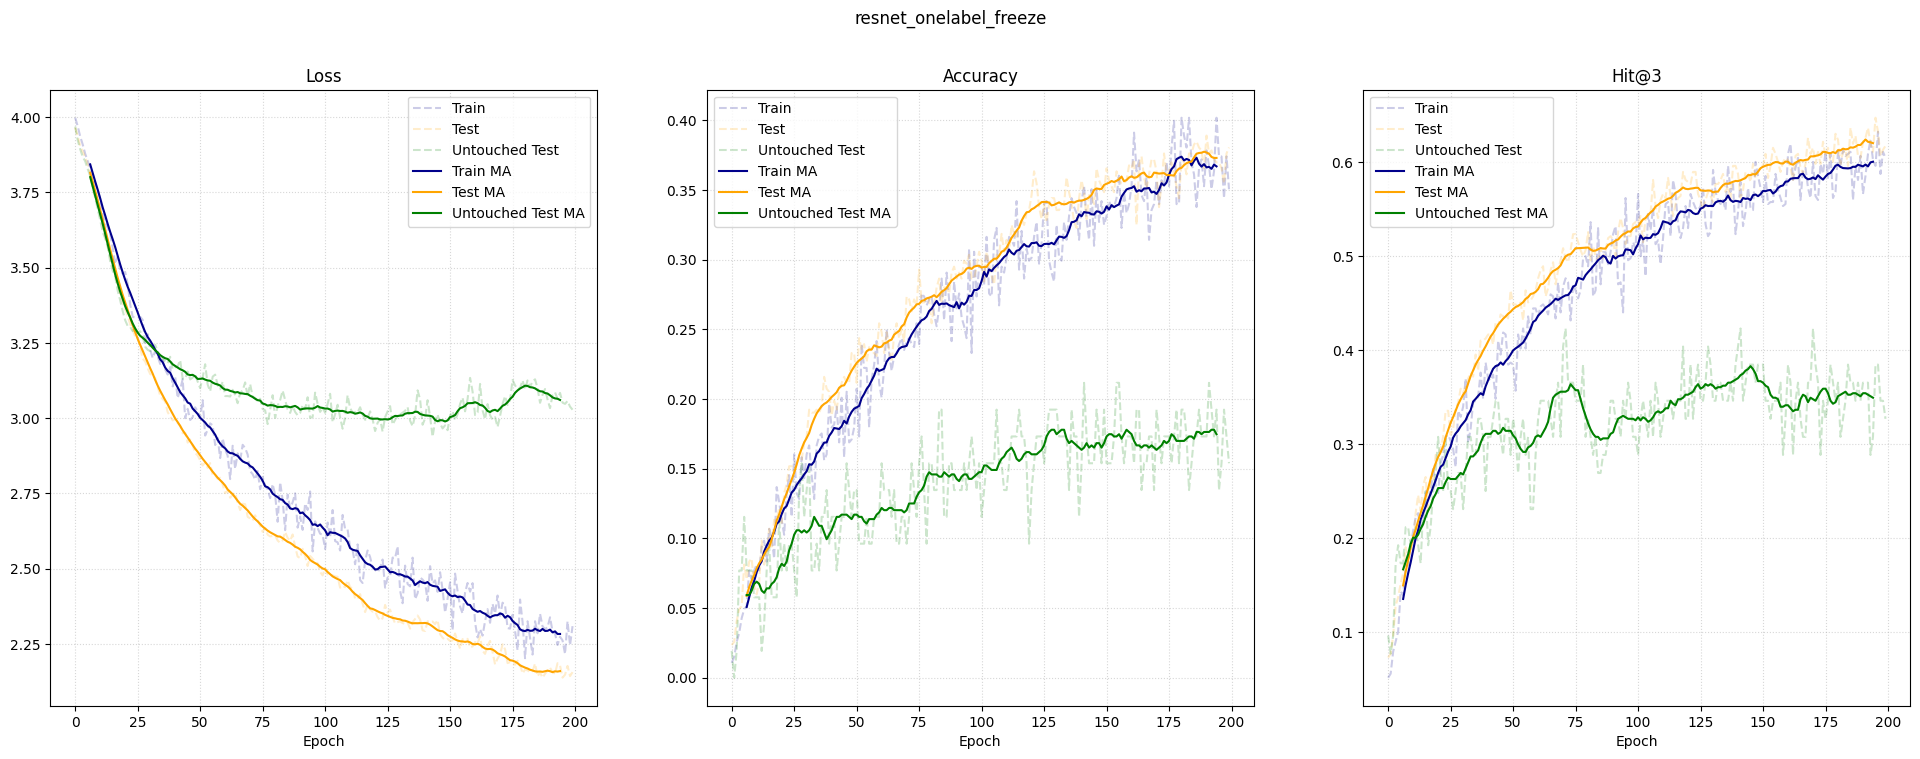

In [13]:
full_train(
    resnet_onelabel_freeze,
    "resnet_onelabel_freeze",
    multilabel=False,
    n_epochs=200,
    print_every=10,
    classifier_only=True,
)

Epoch  10 | Train Loss: 3.1168 | Train Hit@1: 0.1004 | Train Hit@3: 0.2457: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]
          |  Test Loss: 3.0266 |  Test Hit@1: 0.1218 |  Test Hit@3: 0.3056: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
          |  Test Loss: 2.9359 |  Test Hit@1: 0.0769 |  Test Hit@3: 0.2692: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]
Epoch  20 | Train Loss: 2.7334 | Train Hit@1: 0.1774 | Train Hit@3: 0.4038: 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]
          |  Test Loss: 3.0689 |  Test Hit@1: 0.1132 |  Test Hit@3: 0.3120: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
          |  Test Loss: 2.9020 |  Test Hit@1: 0.0962 |  Test Hit@3: 0.3462: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]
Epoch  30 | Train Loss: 2.3795 | Train Hit@1: 0.2500 | Train Hit@3: 0.5043: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]
          |  Test Loss: 2.5714 |  Test Hit@1: 0.2030 |  Test Hit@3: 0.4701: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
          |  Test Loss: 

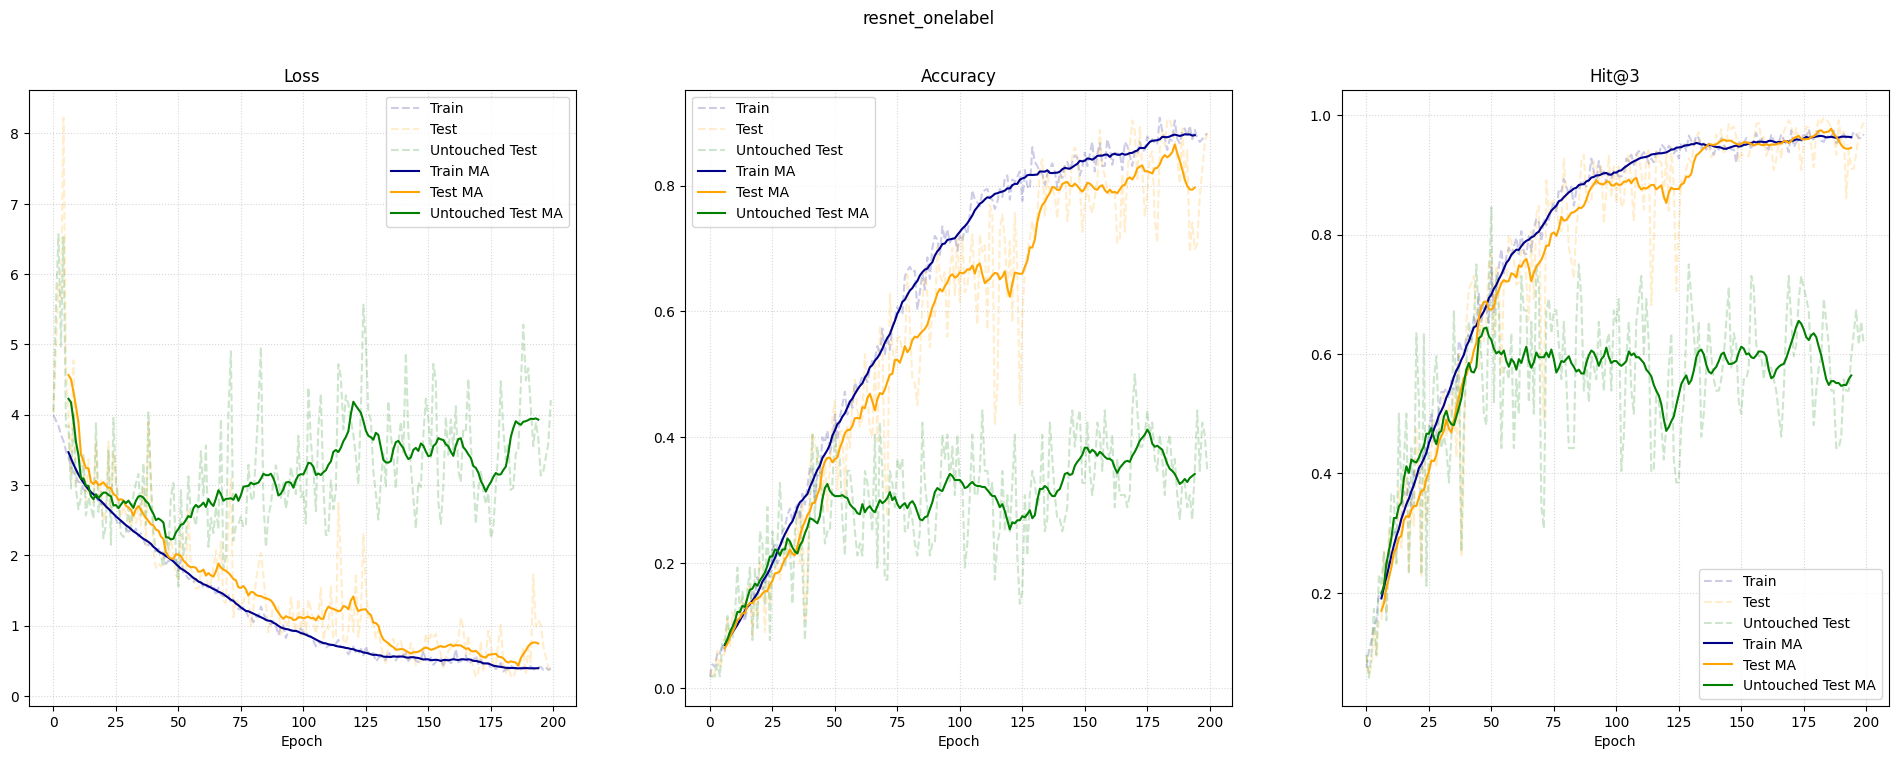

In [14]:
full_train(resnet_onelabel, "resnet_onelabel", multilabel=False, n_epochs=200, print_every=10)

Epoch  10 | Train Loss: 2.7854 | Train Hit@1: 0.1474 | Train Hit@3: 0.5470 | (0.4348 | 0.7682): 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]
          |  Test Loss: 2.8524 |  Test Hit@1: 0.1432 |  Test Hit@3: 0.5385 | (0.4594 | 0.7692): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]
          |  Test Loss: 3.0797 |  Test Hit@1: 0.1346 |  Test Hit@3: 0.6154 | (0.3942 | 0.8077): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
Epoch  20 | Train Loss: 2.4096 | Train Hit@1: 0.2115 | Train Hit@3: 0.6346 | (0.5107 | 0.8162): 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]
          |  Test Loss: 2.2952 |  Test Hit@1: 0.2137 |  Test Hit@3: 0.6709 | (0.5502 | 0.8355): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]
          |  Test Loss: 2.2030 |  Test Hit@1: 0.2692 |  Test Hit@3: 0.7885 | (0.5577 | 0.8942): 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]
Epoch  30 | Train Loss: 2.0624 | Train Hit@1: 0.3248 | Train Hit@3: 0.7030 | (0.6068 | 0.8515): 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]
      

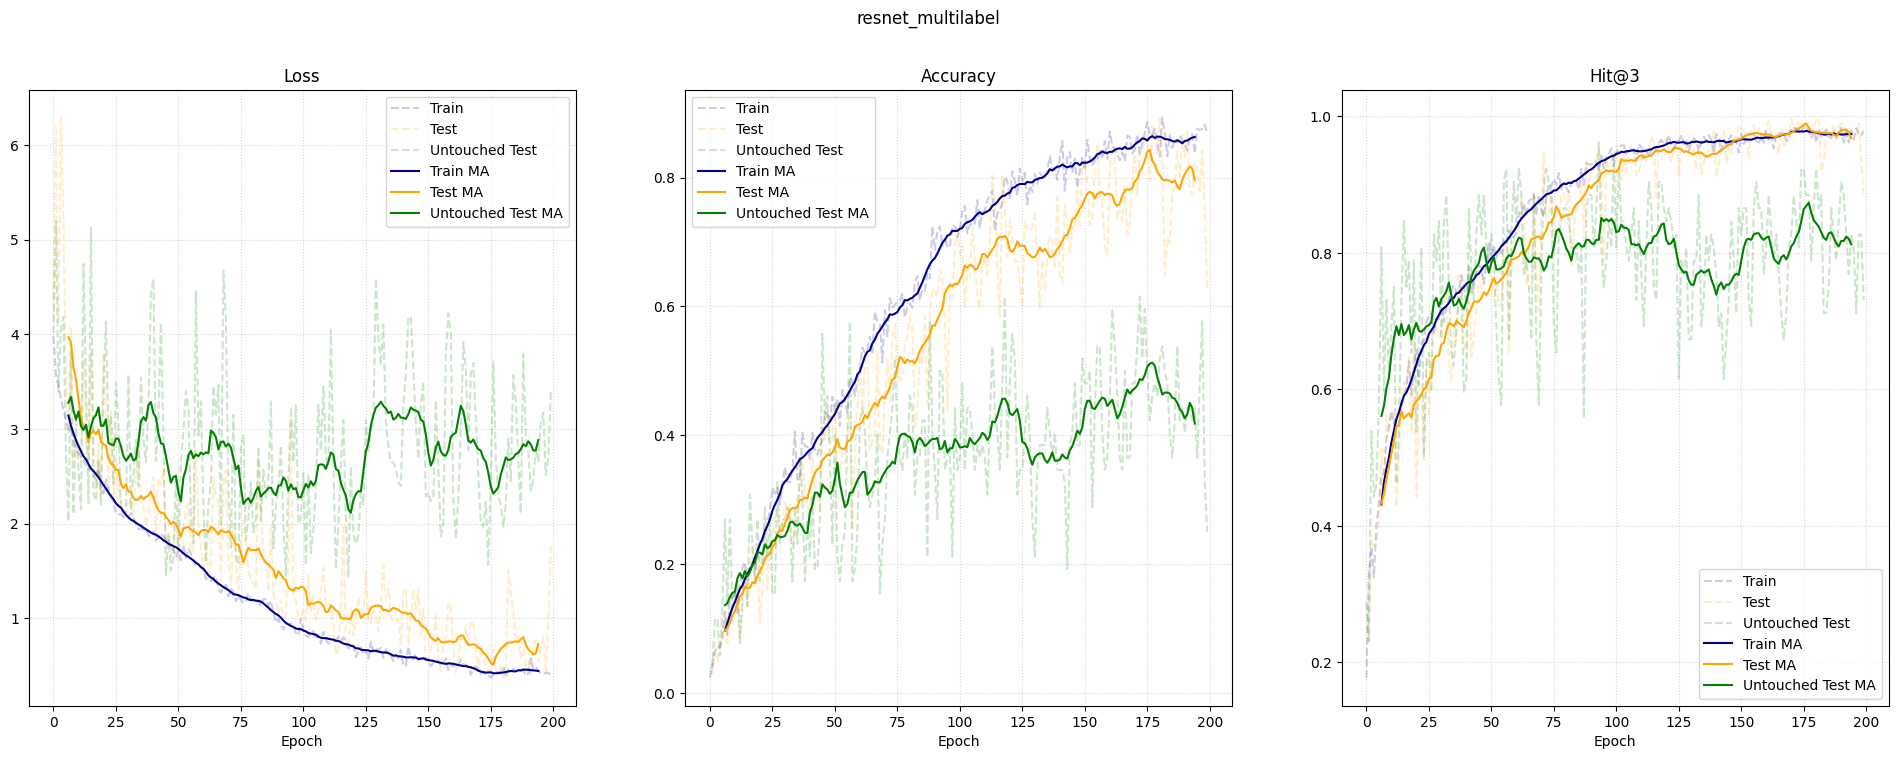

In [15]:
full_train(resnet_multilabel, "resnet_multilabel", multilabel=True, n_epochs=200, print_every=10)

Epoch  10 | Train Loss: 2.3727 | Train Hit@1: 0.2714 | Train Hit@3: 0.6410 | (0.5566 | 0.8194): 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]
          |  Test Loss: 2.1531 |  Test Hit@1: 0.3077 |  Test Hit@3: 0.6816 | (0.6132 | 0.8397): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]
          |  Test Loss: 2.8070 |  Test Hit@1: 0.2885 |  Test Hit@3: 0.6538 | (0.5481 | 0.8269): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
Epoch  20 | Train Loss: 1.5101 | Train Hit@1: 0.4915 | Train Hit@3: 0.8547 | (0.7201 | 0.9274): 100%|██████████| 4/4 [00:09<00:00,  2.50s/it]
          |  Test Loss: 1.0515 |  Test Hit@1: 0.6517 |  Test Hit@3: 0.9509 | (0.8120 | 0.9754): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]
          |  Test Loss: 1.7761 |  Test Hit@1: 0.3269 |  Test Hit@3: 0.8654 | (0.6250 | 0.9327): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
Epoch  30 | Train Loss: 0.9374 | Train Hit@1: 0.6987 | Train Hit@3: 0.9466 | (0.8355 | 0.9733): 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]
      

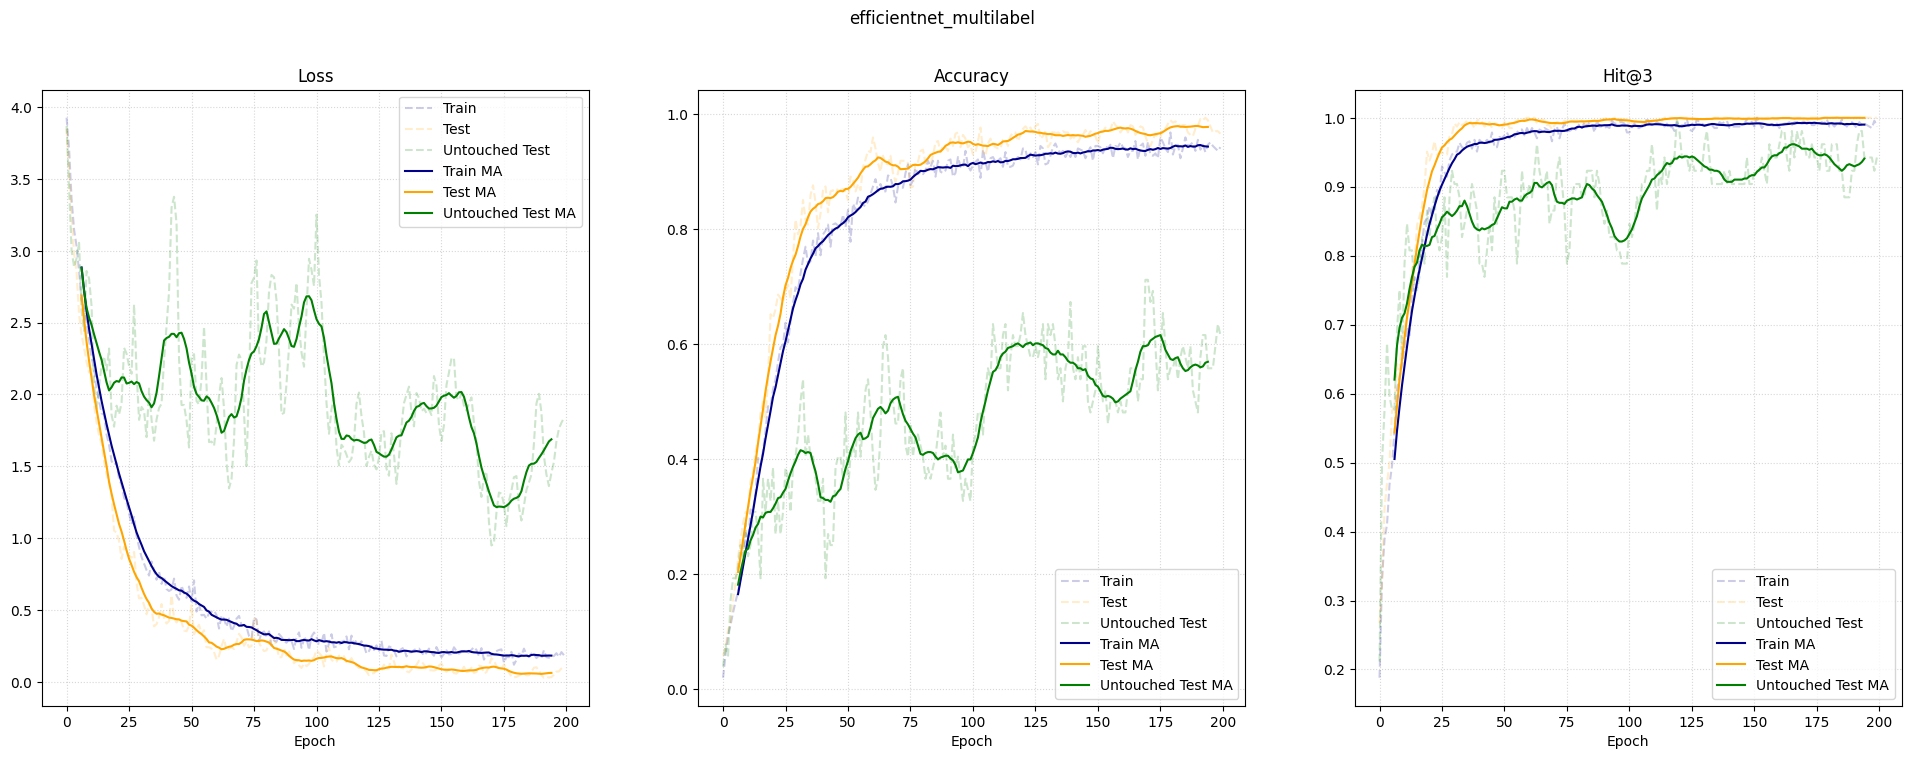

In [16]:
full_train(efficientnet_multilabel, "efficientnet_multilabel", multilabel=True, n_epochs=200, print_every=10)

Epoch  10 | Train Loss: 2.2816 | Train Hit@1: 0.2543 | Train Hit@3: 0.6603 | (0.5577 | 0.8291): 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]
          |  Test Loss: 4.6159 |  Test Hit@1: 0.1047 |  Test Hit@3: 0.4423 | (0.4028 | 0.7083): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]
          |  Test Loss: 4.2489 |  Test Hit@1: 0.0385 |  Test Hit@3: 0.5000 | (0.3269 | 0.7500): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]
Epoch  20 | Train Loss: 1.5503 | Train Hit@1: 0.4936 | Train Hit@3: 0.8590 | (0.7094 | 0.9274): 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]
          |  Test Loss: 4.0078 |  Test Hit@1: 0.1880 |  Test Hit@3: 0.5556 | (0.4882 | 0.7714): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
          |  Test Loss: 3.7752 |  Test Hit@1: 0.1346 |  Test Hit@3: 0.6154 | (0.4423 | 0.8077): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]
Epoch  30 | Train Loss: 1.0580 | Train Hit@1: 0.6624 | Train Hit@3: 0.9103 | (0.8184 | 0.9541): 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]
      

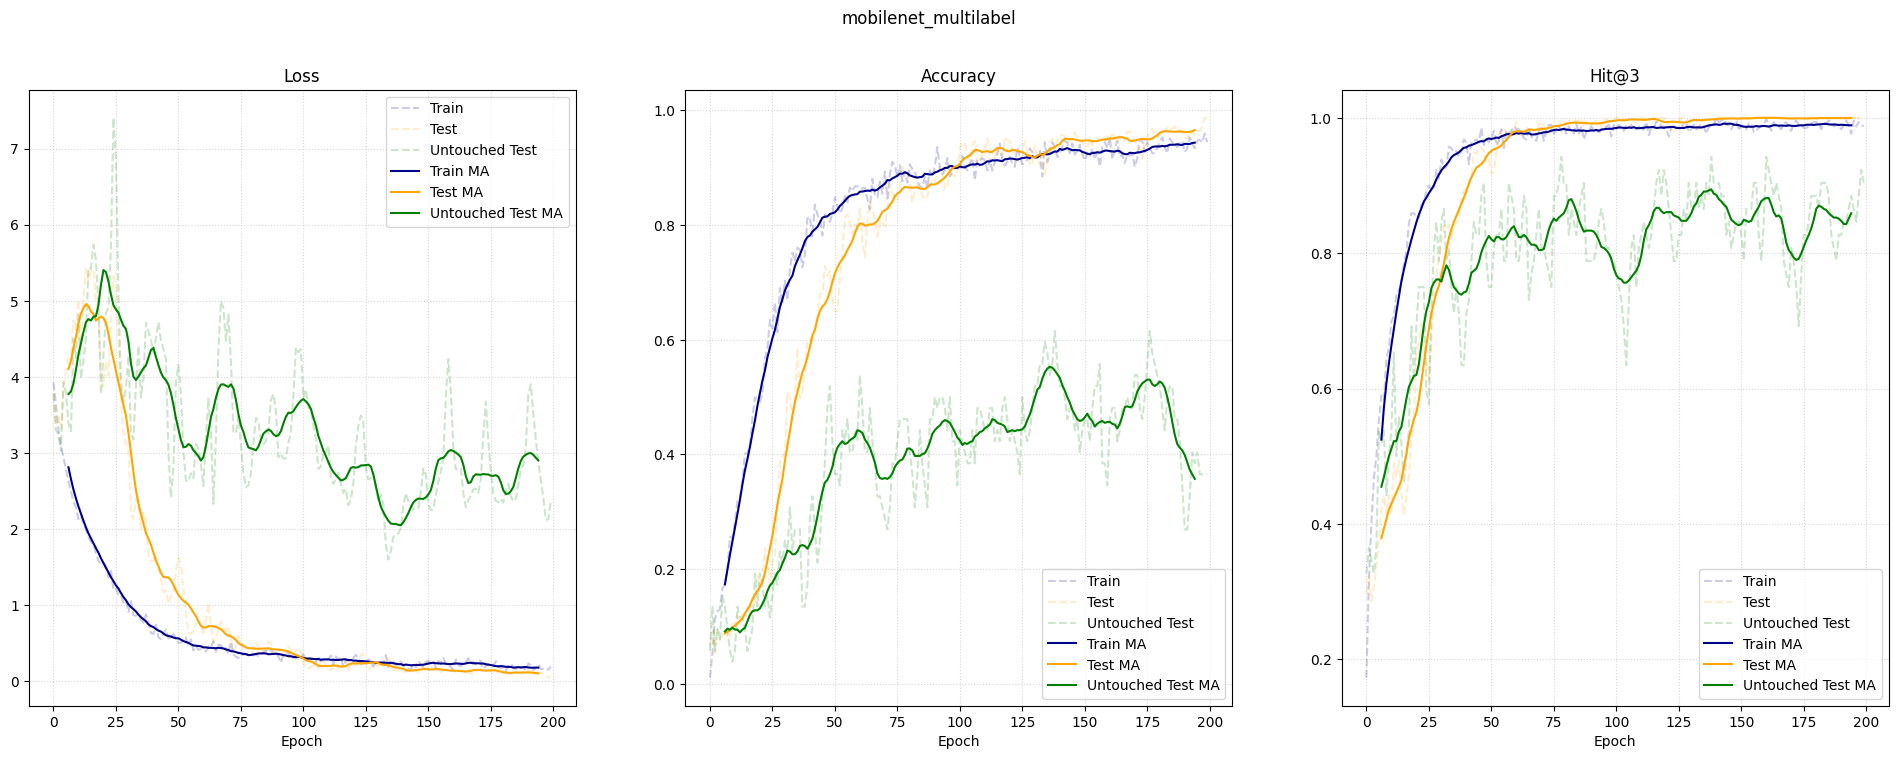

In [22]:
full_train(mobilenet_multilabel, "mobilenet_multilabel", multilabel=True, n_epochs=200, print_every=10)

## Измерение качества

Загружаем модели, полученные с обучения:

In [126]:
resnet_onelabel_freeze, _ = load("resnet_onelabel_freeze")
resnet_onelabel, _ = load("resnet_onelabel")
resnet_multilabel, _ = load("resnet_multilabel")
efficientnet_multilabel, _ = load("efficientnet_multilabel")
mobilenet_multilabel, _ = load("mobilenet_multilabel")

all_models = [resnet_onelabel_freeze, resnet_onelabel, resnet_multilabel, efficientnet_multilabel, mobilenet_multilabel]
all_models_features = [
    resnet_onelabel_freeze.backbone.layer4,
    resnet_onelabel.backbone.layer4,
    resnet_multilabel.backbone.layer4,
    efficientnet_multilabel.backbone.features[-1],
    mobilenet_multilabel.backbone.features[-1],
]
all_models_names = [
    "resnet_onelabel_freeze",
    "resnet_onelabel",
    "resnet_multilabel",
    "efficientnet_multilabel",
    "mobilenet_multilabel",
]

for model in all_models:
    model.eval()
    for p in model.parameters():
        p.requires_grad = True

Функции для сравнительного анализа:

In [ ]:
def compare_metrics_graph(names):
    alldata = {}
    for name in names:
        model, data = load(name)
        alldata[name] = data

    for part in ["train", "test", "untouched_test"]:
        plt.figure(figsize=(24, 8))
        plt.suptitle(part)
        for i, metric in enumerate(["loss", "hit1_full", "hit3_full"]):
            plt.subplot(1, 3, i + 1)
            for model_name, data in alldata.items():
                metric_lst = [v[f"{part}_{metric}"] for v in data]

                plt.plot(moving_average(np.array(metric_lst)), label=f"{model_name}")

            plt.legend()
            plt.grid(alpha=0.5, linestyle=":")
            plt.xlabel("Epoch")
            plt.title(metric)

        plt.show()


def compare_metrics_table(names):
    alldata = {}
    for name in names:
        model, data = load(name)
        alldata[name] = (data, sum(p.numel() for p in model.parameters()))

    df = []

    for name, (data, parameters) in alldata.items():
        row = {
            "model": name,
            "parameters": parameters,
            "train_loss": data[-1]["train_loss"],
            "test_loss": data[-1]["test_loss"],
            "untouched_test_loss": data[-1]["untouched_test_loss"],
            "train_hit@1": data[-1]["train_hit1_full"],
            "train_hit@3": data[-1]["train_hit3_full"],
            "test_hit@1": data[-1]["test_hit1_full"],
            "test_hit@3": data[-1]["test_hit3_full"],
            "untouched_test_hit@1": data[-1]["untouched_test_hit1_full"],
            "untouched_test_hit@3": data[-1]["untouched_test_hit3_full"],
            "train_time": data[-1]["train_time"],
            "test_time": data[-1]["test_time"],
        }
        df.append(row)

    display(pd.DataFrame(df).round(4).style.background_gradient(cmap="YlGn"))

Сравнительный анализ:

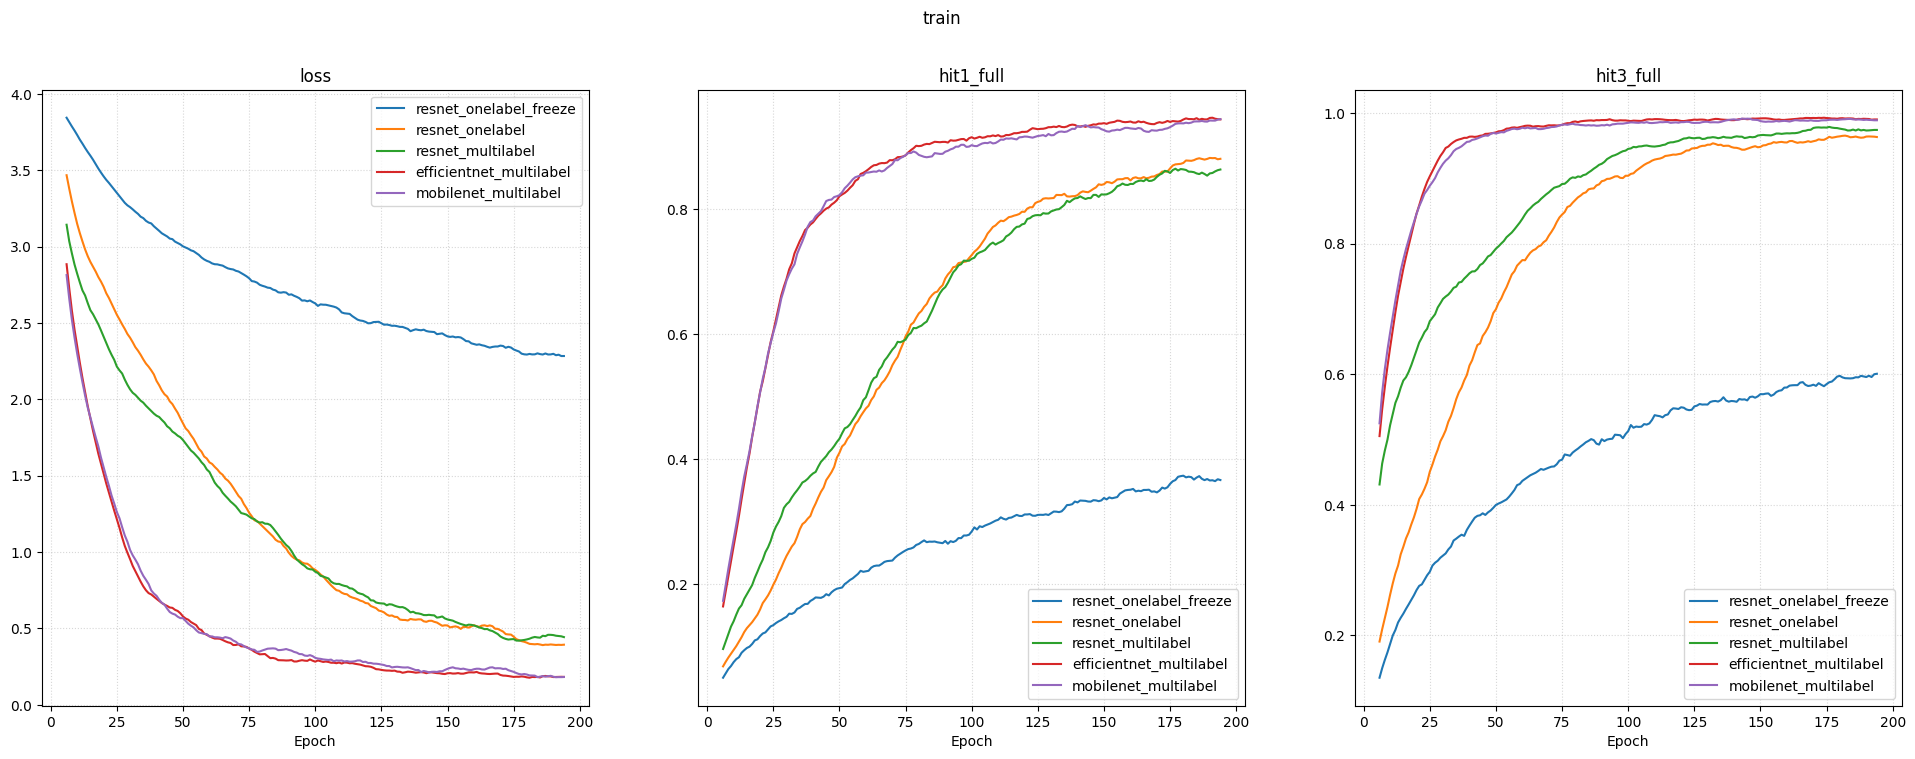

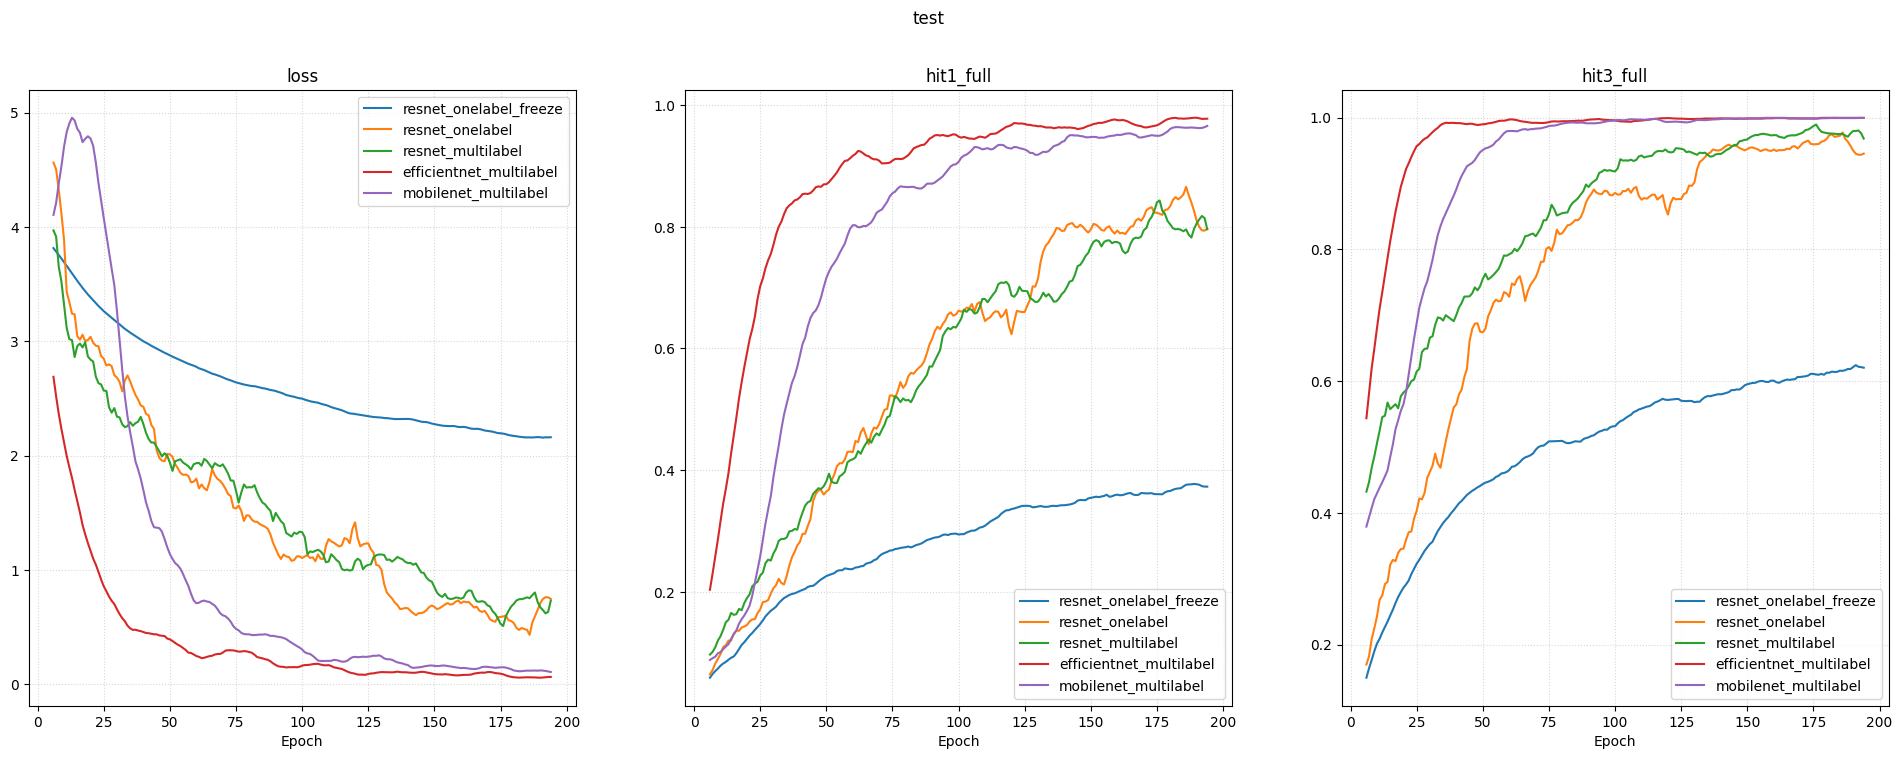

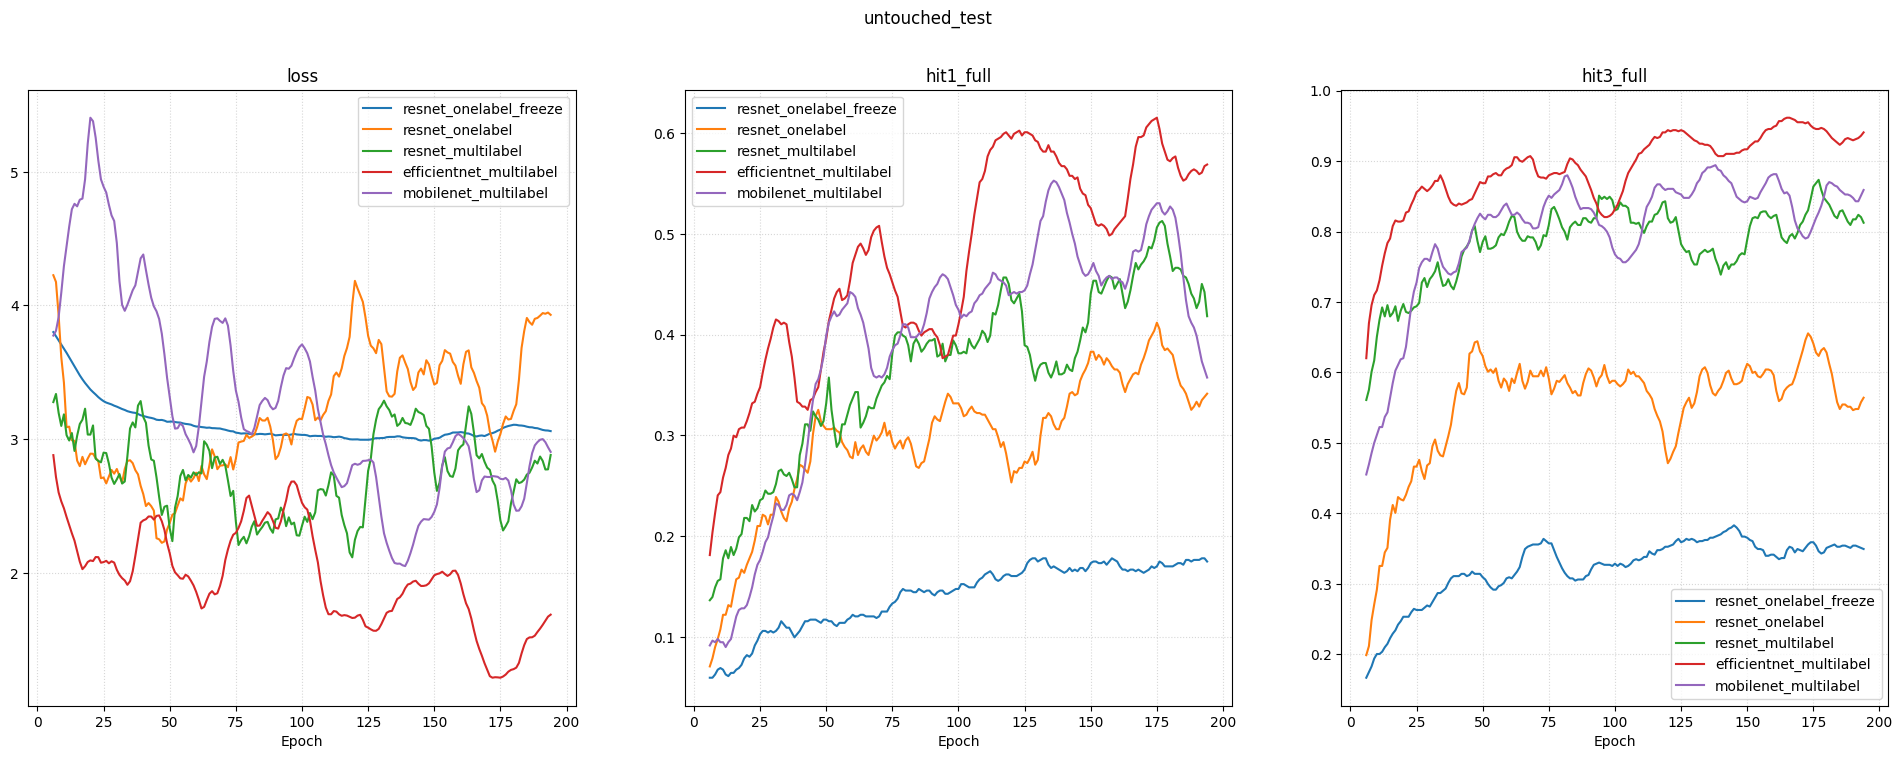

In [163]:
compare_metrics_graph(all_models_names)

In [164]:
compare_metrics_table(all_models_names)

Просмотр GradCAM:

In [165]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


class CamMultilabelExtractor(nn.Module):
    def __init__(self, model, classifier=1, is_multilabel=False):
        super().__init__()
        self.model = model
        self.classifier = classifier
        self.is_multilabel = is_multilabel

    def forward(self, x):
        if self.is_multilabel:
            out1, out2 = self.model(x)
            if self.classifier == 1:
                return out1
            return out2
        else:
            return self.model(x)

In [166]:
def compare_grad(img, test_dataset, dataset):
    img1, labels1 = test_dataset[img]
    input_tensor1 = img1.unsqueeze(0)

    img2, labels2 = dataset[img]
    input_tensor2 = img2.unsqueeze(0)

    for classifier_type_name, classifier_type in zip(["Достоинство", "Масть"], [0, 1]):
        plt.figure(figsize=(16, 8))
        plt.suptitle(classifier_type_name)

        ind = 1

        for model_name, model, layers, is_multilabel in list(
            zip(all_models_names, all_models, all_models_features, [False, False, True, True, True])
        ):
            plt.subplot(2, 5, ind)
            targets = [ClassifierOutputTarget(labels1[classifier_type])]
            cam_model = CamMultilabelExtractor(model, classifier_type + 1, is_multilabel=is_multilabel)

            with GradCAMPlusPlus(model=cam_model, target_layers=layers) as cam:
                grayscale_cam = cam(input_tensor=input_tensor1, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(
                    img1.permute(1, 2, 0).numpy().clip(0, 1), grayscale_cam, use_rgb=True, image_weight=0.3
                )

            plt.imshow(visualization)
            plt.title(model_name)
            plt.axis("off")

            ind += 1

            plt.subplot(2, 5, ind + 4)
            targets = [ClassifierOutputTarget(labels2[classifier_type])]
            cam_model = CamMultilabelExtractor(model, classifier_type + 1)

            with GradCAMPlusPlus(model=cam_model, target_layers=layers) as cam:
                grayscale_cam = cam(input_tensor=input_tensor2, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(
                    img2.permute(1, 2, 0).numpy().clip(0, 1), grayscale_cam, use_rgb=True, image_weight=0.3
                )

            plt.imshow(visualization)
            plt.title(model_name)
            plt.axis("off")

        plt.show()

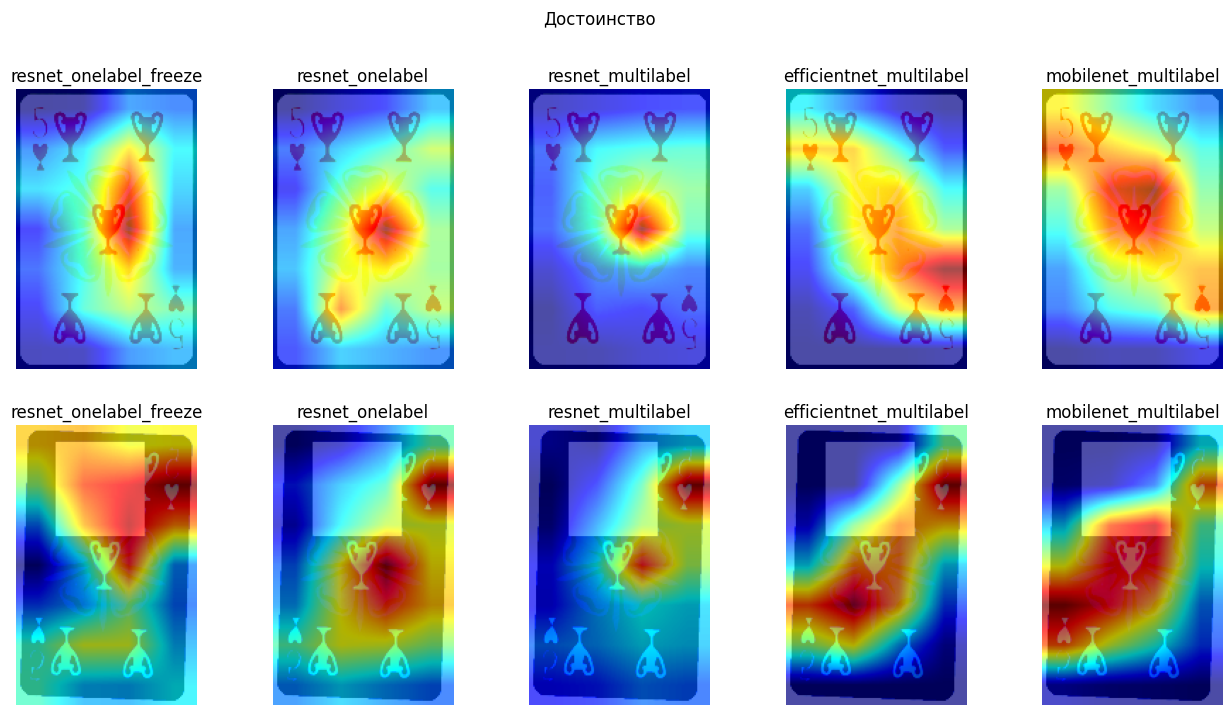

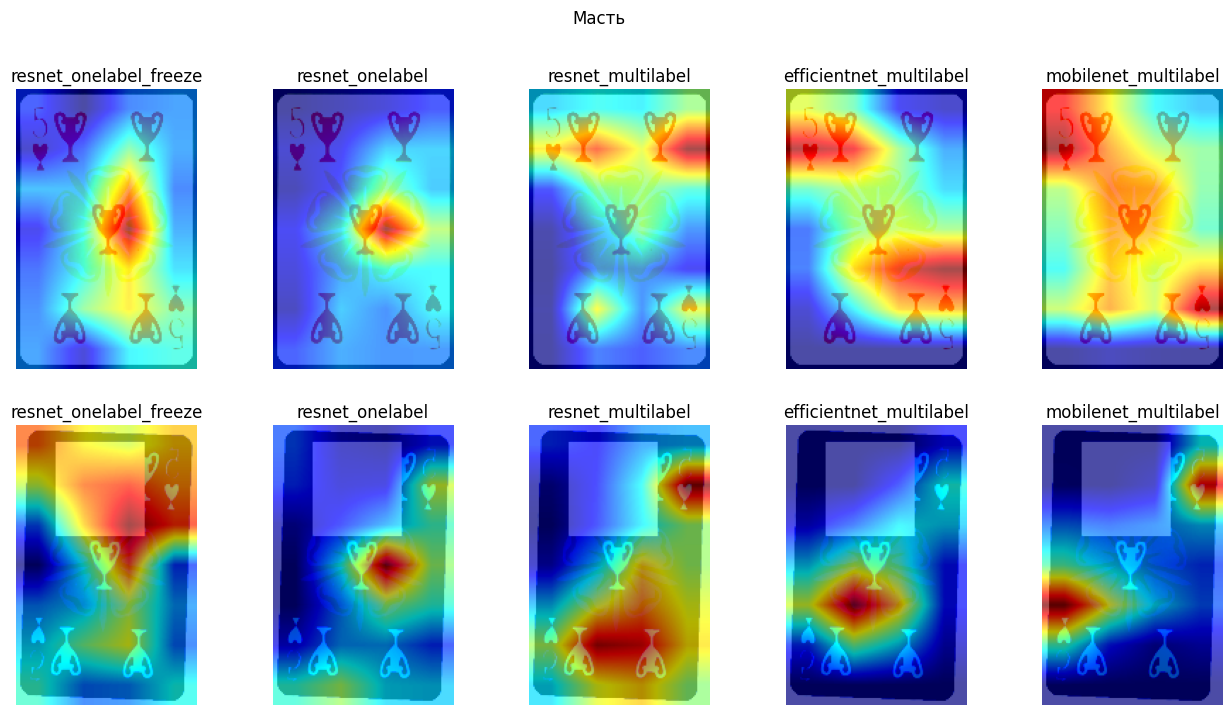

In [ ]:
compare_grad(2, test_dataset, dataset)

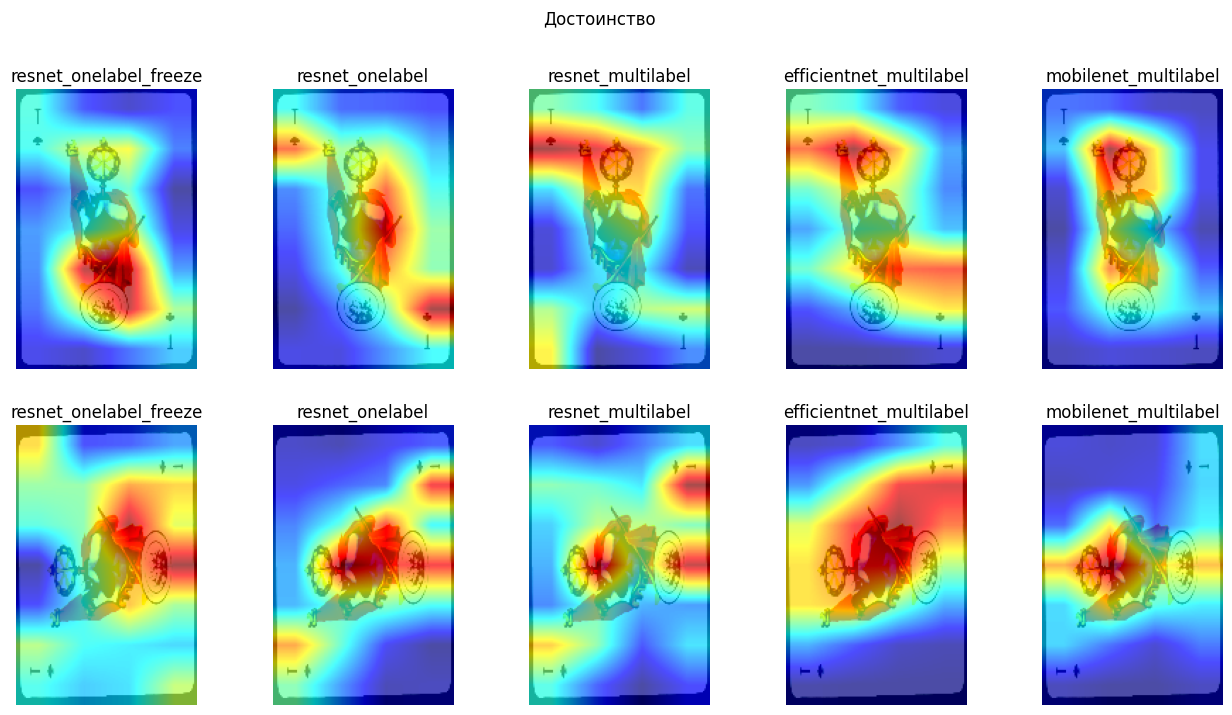

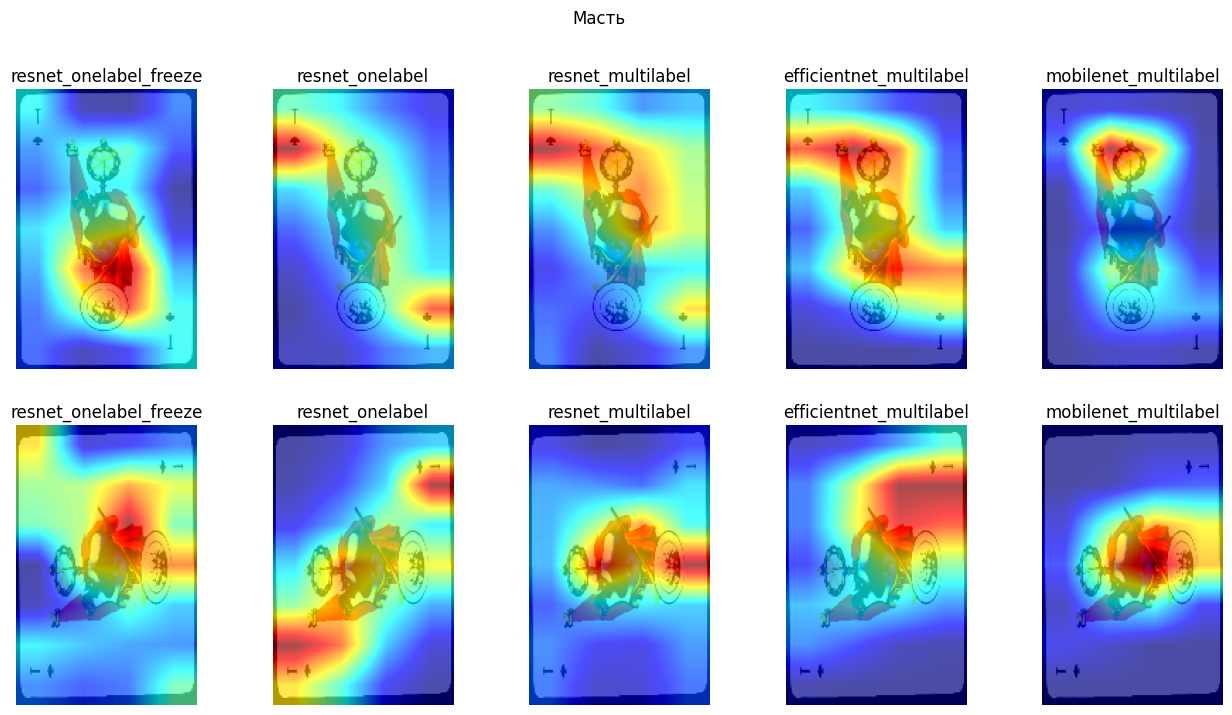

In [180]:
compare_grad(5, untouched_test_dataset, untouched_dataset)

Дообучение лучшей модели на более низком learning rate:

Epoch   5 | Train Loss: 0.1644 | Train Hit@1: 0.9466 | Train Hit@3: 0.9893 | (0.9733 | 0.9947): 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]
          |  Test Loss: 0.0291 |  Test Hit@1: 0.9915 |  Test Hit@3: 1.0000 | (0.9957 | 1.0000): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
          |  Test Loss: 1.2461 |  Test Hit@1: 0.6154 |  Test Hit@3: 0.9615 | (0.7981 | 0.9808): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]
Epoch  10 | Train Loss: 0.1259 | Train Hit@1: 0.9637 | Train Hit@3: 0.9936 | (0.9818 | 0.9968): 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]
          |  Test Loss: 0.0201 |  Test Hit@1: 0.9957 |  Test Hit@3: 1.0000 | (0.9979 | 1.0000): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
          |  Test Loss: 1.3602 |  Test Hit@1: 0.5577 |  Test Hit@3: 0.9808 | (0.7692 | 0.9904): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]
Epoch  15 | Train Loss: 0.1634 | Train Hit@1: 0.9509 | Train Hit@3: 0.9808 | (0.9744 | 0.9904): 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]
      

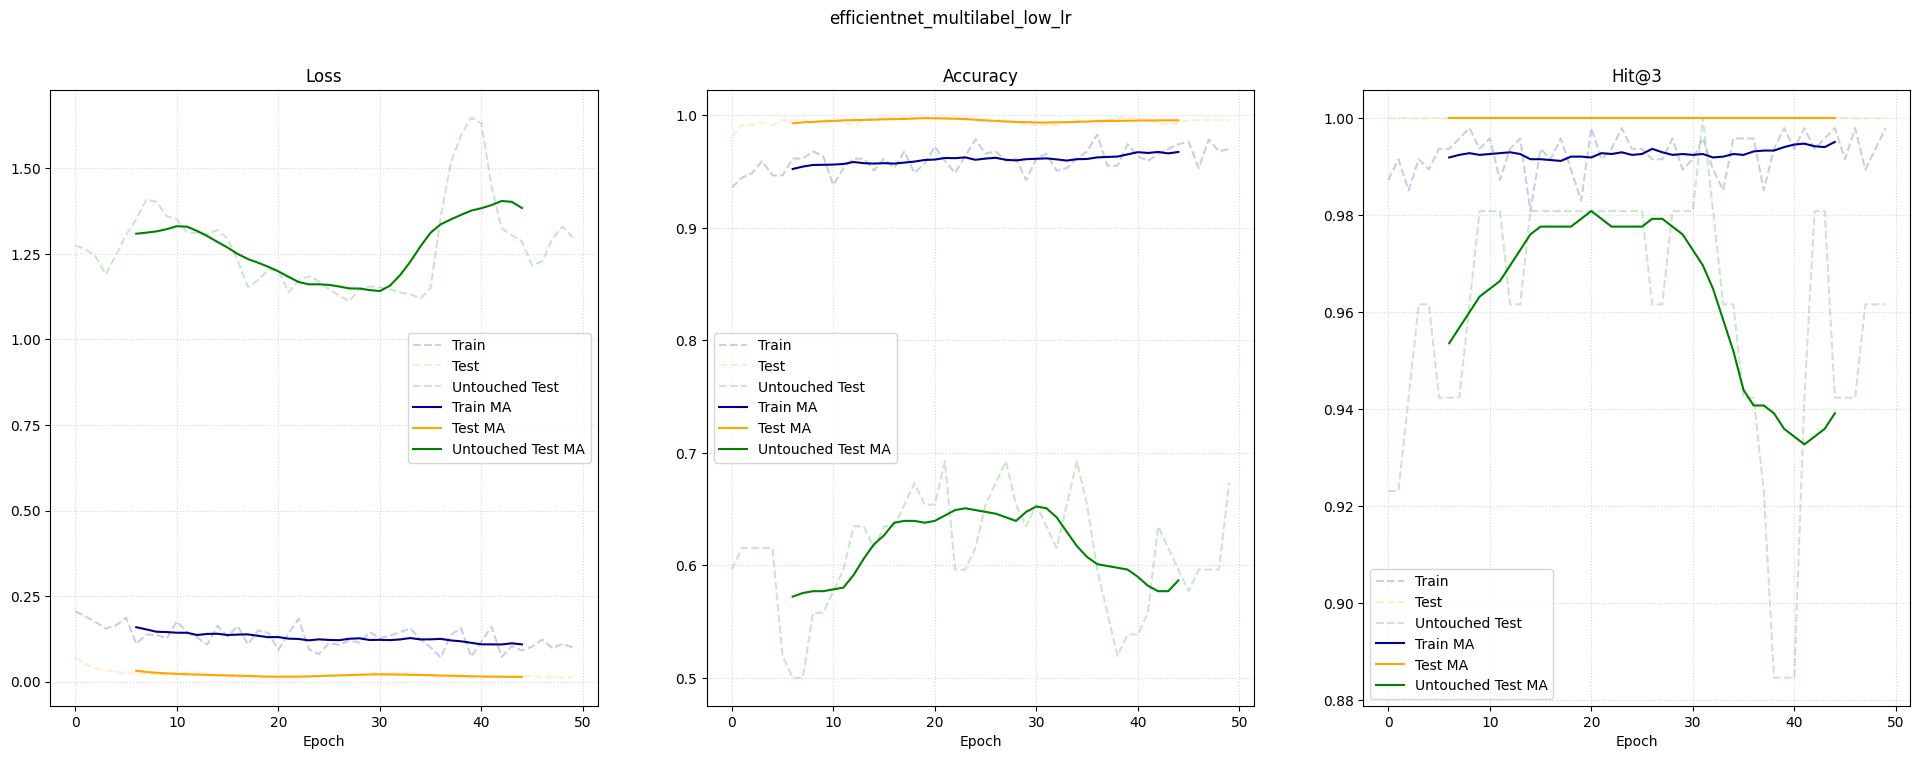

In [ ]:
full_train(
    efficientnet_multilabel, "efficientnet_multilabel_low_lr", multilabel=True, n_epochs=50, print_every=5, lr=0.0003
)

In [ ]:
compare_metrics_table(["efficientnet_multilabel_low_lr"])

Эксперимент с вычислительной сложностью:

In [143]:
efficientnet_multilabel_backbone_new = tv.models.efficientnet_b0(
    weights=tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1
)
efficientnet_multilabel_backbone_new.classifier = nn.Identity()

efficientnet_multilabel_new = CardImageResolverMultilabel(
    efficientnet_multilabel_backbone_new, classifier(1280, 13), classifier(1280, 4)
)

efficientnet_multilabel_with_learned_backbone = CardImageResolverMultilabel(
    efficientnet_multilabel.backbone, classifier(1280, 13), classifier(1280, 4)
)

Epoch   2 | Train Loss: 3.8525 | Train Hit@1: 0.0385 | Train Hit@3: 0.3077 | (0.2692 | 0.6154): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
          |  Test Loss: 3.8235 |  Test Hit@1: 0.0769 |  Test Hit@3: 0.2692 | (0.3173 | 0.6058): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
          |  Test Loss: 3.8235 |  Test Hit@1: 0.0769 |  Test Hit@3: 0.2692 | (0.3173 | 0.6058): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]
Epoch   4 | Train Loss: 3.6205 | Train Hit@1: 0.1538 | Train Hit@3: 0.5577 | (0.4135 | 0.7692): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
          |  Test Loss: 3.5766 |  Test Hit@1: 0.1346 |  Test Hit@3: 0.4615 | (0.3750 | 0.7308): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]
          |  Test Loss: 3.5766 |  Test Hit@1: 0.1346 |  Test Hit@3: 0.4615 | (0.3750 | 0.7308): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
Epoch   6 | Train Loss: 3.3169 | Train Hit@1: 0.1731 | Train Hit@3: 0.5769 | (0.4712 | 0.7885): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
      

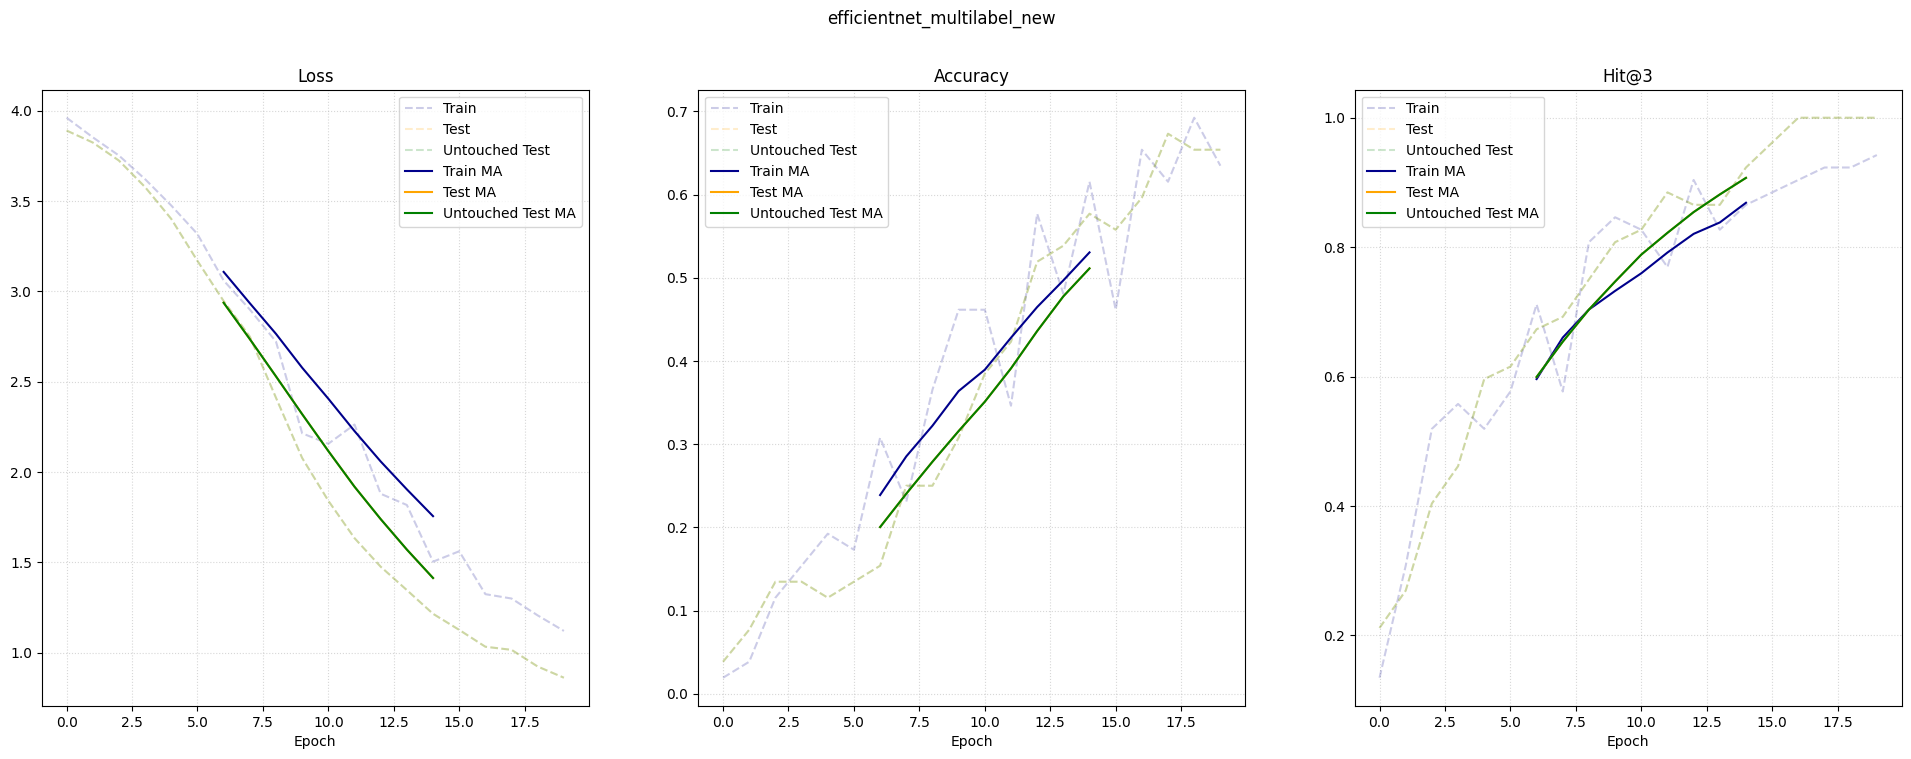

In [ ]:
full_train(
    efficientnet_multilabel_new,
    "efficientnet_multilabel_new",
    multilabel=True,
    n_epochs=20,
    print_every=2,
    use_untouched=True,
)

Epoch   2 | Train Loss: 3.3403 | Train Hit@1: 0.4231 | Train Hit@3: 0.6346 | (0.7019 | 0.8173): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
          |  Test Loss: 2.8599 |  Test Hit@1: 0.5000 |  Test Hit@3: 0.8269 | (0.7404 | 0.9135): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
          |  Test Loss: 2.8599 |  Test Hit@1: 0.5000 |  Test Hit@3: 0.8269 | (0.7404 | 0.9135): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]
Epoch   4 | Train Loss: 2.2386 | Train Hit@1: 0.7500 | Train Hit@3: 0.9038 | (0.8750 | 0.9519): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
          |  Test Loss: 1.7598 |  Test Hit@1: 0.6346 |  Test Hit@3: 0.9231 | (0.8173 | 0.9615): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]
          |  Test Loss: 1.7598 |  Test Hit@1: 0.6346 |  Test Hit@3: 0.9231 | (0.8173 | 0.9615): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
Epoch   6 | Train Loss: 1.4470 | Train Hit@1: 0.7500 | Train Hit@3: 0.9423 | (0.8750 | 0.9712): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
      

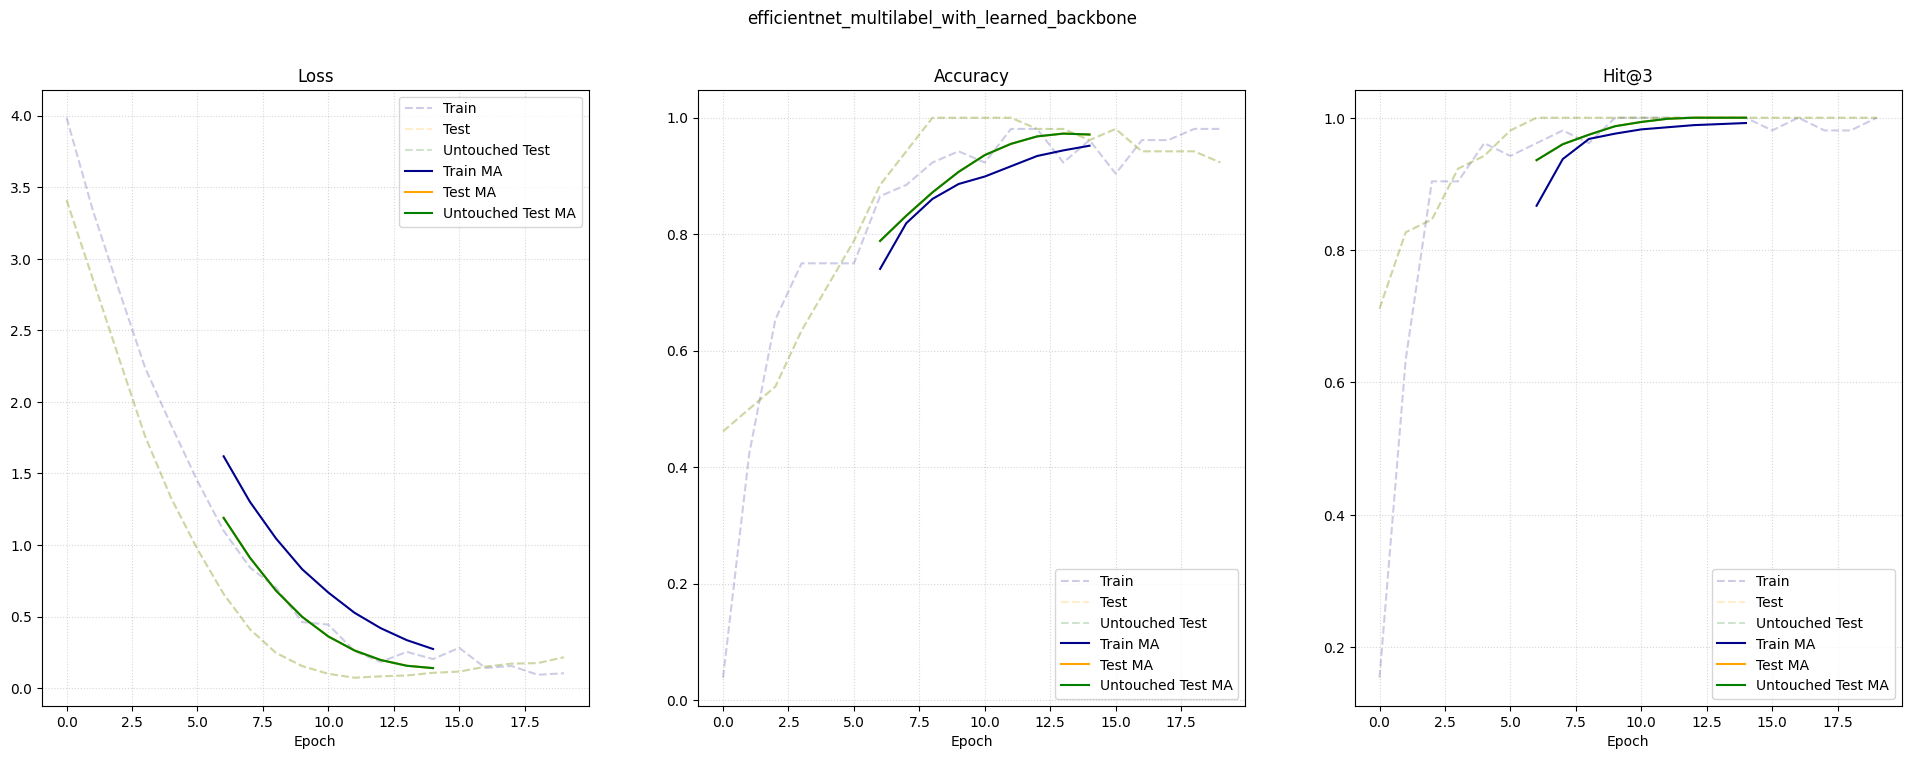

In [146]:
full_train(
    efficientnet_multilabel_with_learned_backbone,
    "efficientnet_multilabel_with_learned_backbone",
    multilabel=True,
    n_epochs=20,
    print_every=2,
    use_untouched=True,
)

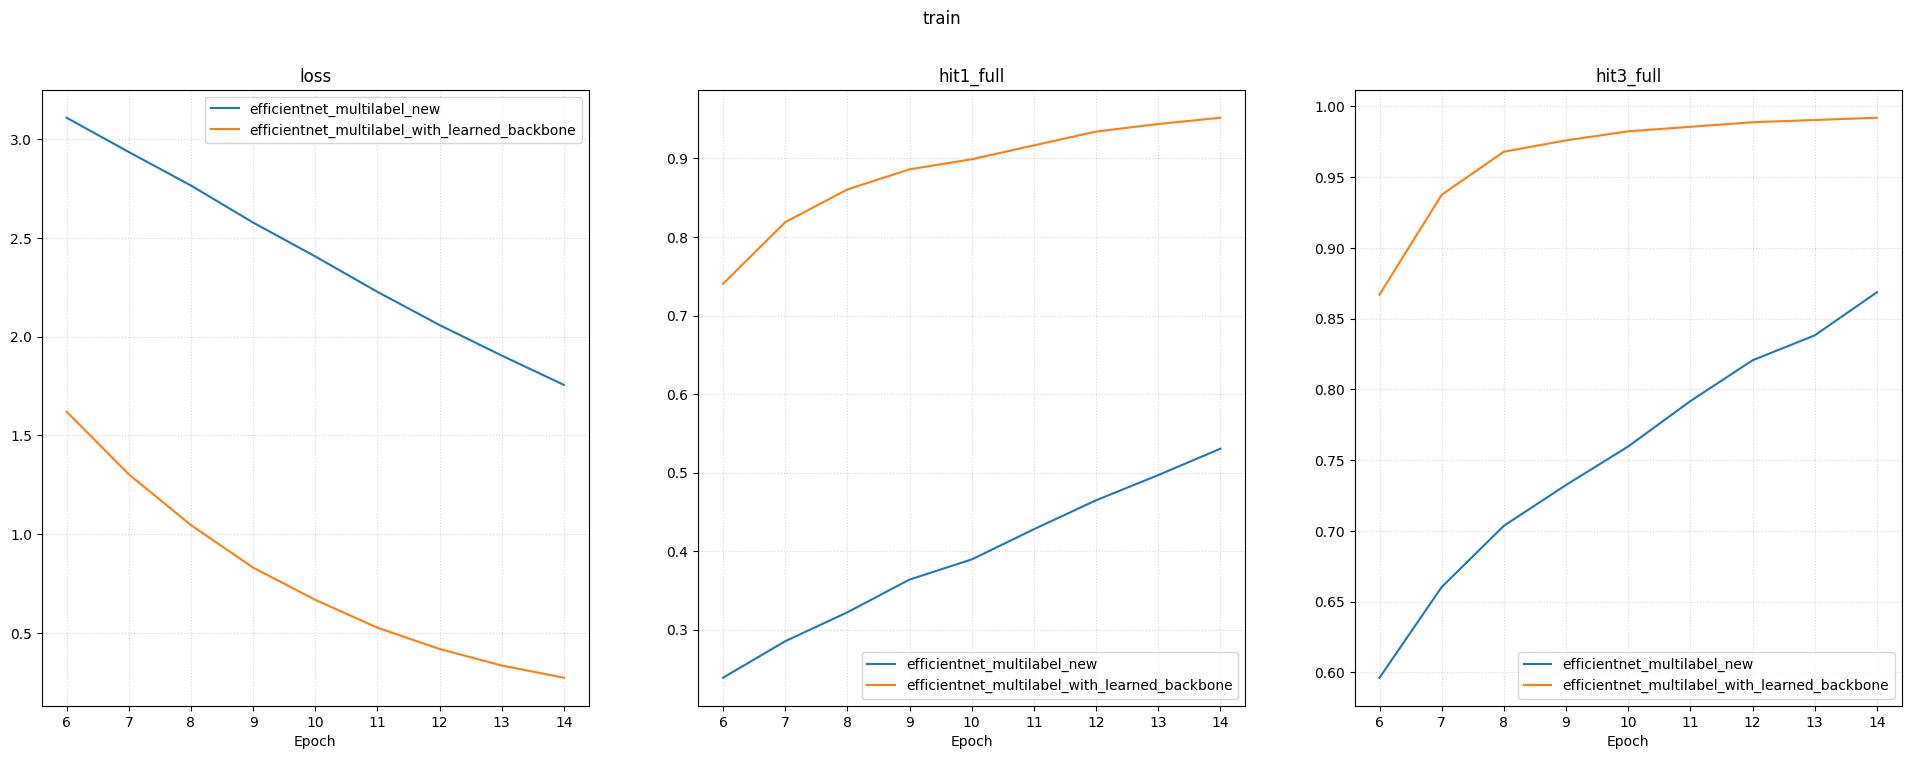

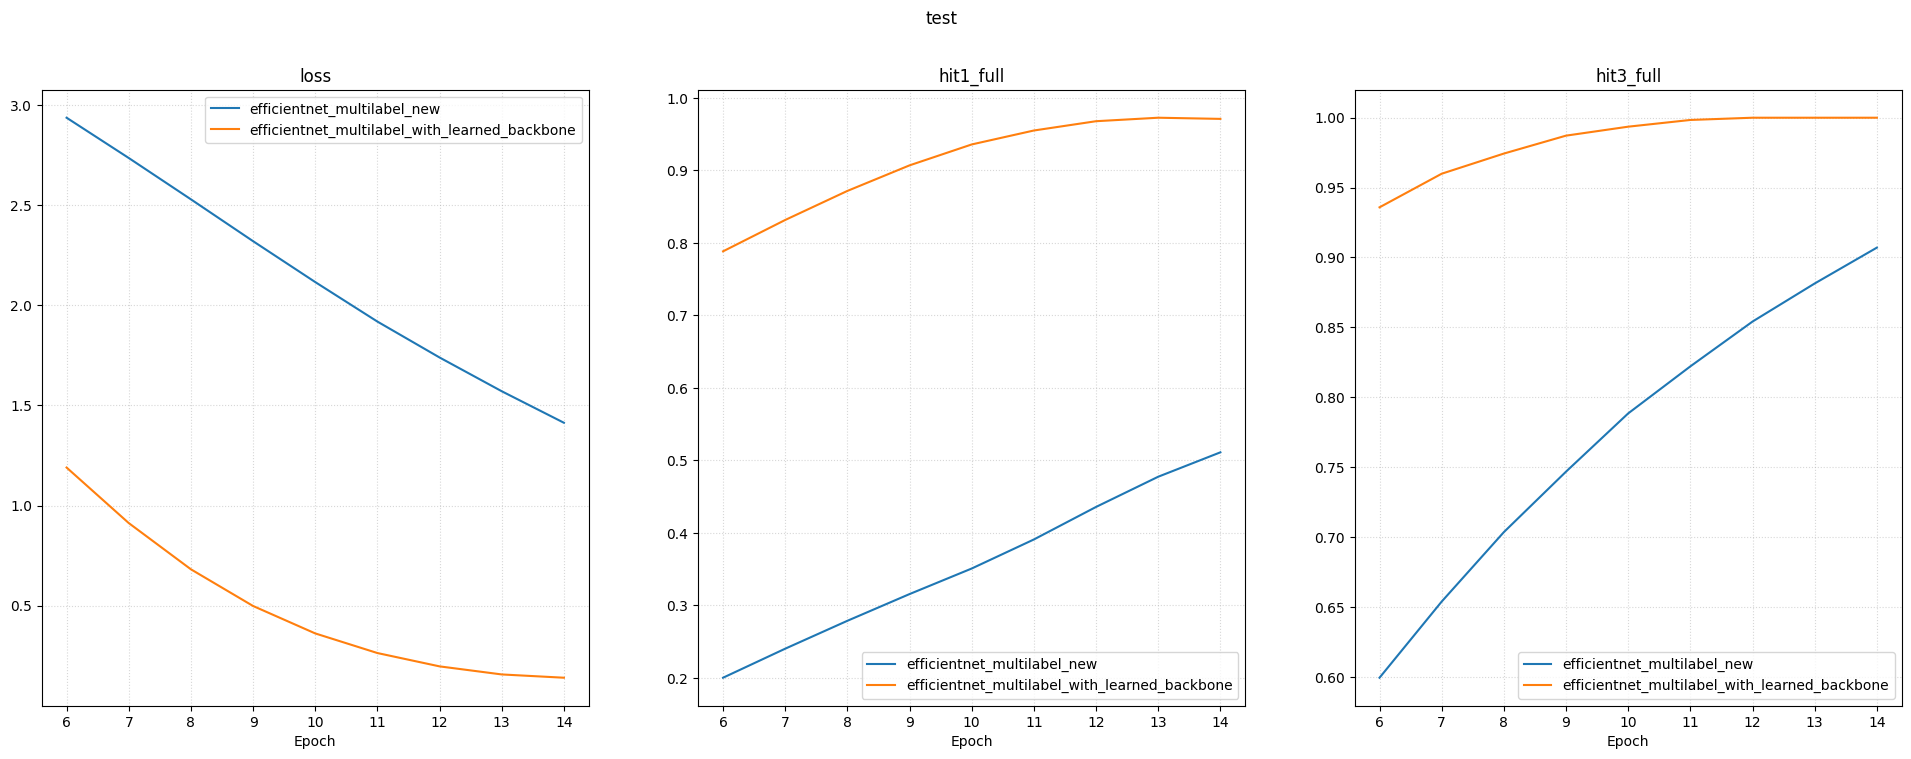

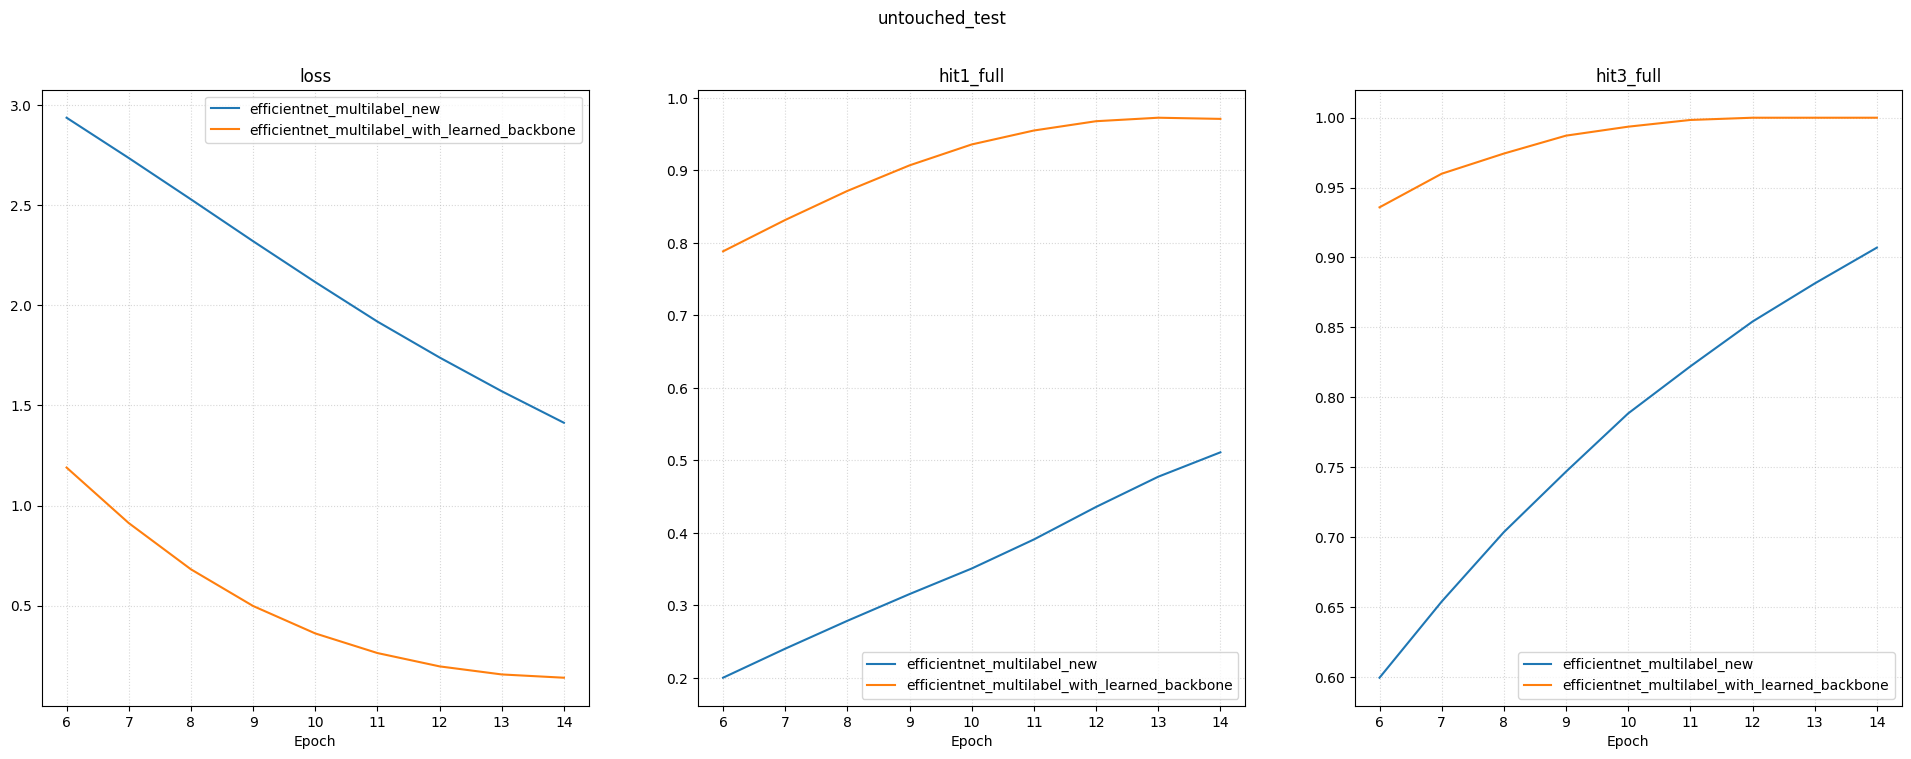

In [147]:
compare_metrics_graph(["efficientnet_multilabel_new", "efficientnet_multilabel_with_learned_backbone"])

In [161]:
compare_metrics_table(["efficientnet_multilabel_new", "efficientnet_multilabel_with_learned_backbone"])